In [200]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Preprocessor
---------------------

In [201]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        
        result = self._merge(result, non_numeric)
        result = self._add_sub_diff(result)
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result, non_numeric)

        return result
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
        
    def _str_to_datetype(self,result):
        #csv파일 로드시 date 컬럼이 str 타입으로 읽혀진 경우 이를 datetype으로 변환
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
    
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data[non_numeric].iloc[0,:], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operates both merge and creating video_num featrue
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_sub_diff(result):
        result = result.reset_index(drop=True)
        result['sub_diff'] = (result['cumul_subs'] - result['cumul_subs'].shift())
        return result
    def _add_sub_diff(self,result):
        result = result.groupby('channel').apply(lambda x: self._get_sub_diff(x)).reset_index(drop=True)
        result.loc[result.sub_diff.isna(), 'sub_diff'] = 0
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result, non_numeric):
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, drop_features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train.drop(drop_features, axis=1), target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, drop_features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #drop_features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if drop_features is None:
            drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, drop_features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        
        #data=self.__tanh_scaling(data)
        
        if return_original_scale:
            return data, original_scale
        return data
    
    
    @staticmethod
    def __tanh_scaling(df):
        "tanh_scaling을 통해 -->[0,1]로 scaling"
        meta=pd.DataFrame()
        meta_mean=np.mean(df)
        meta_std=np.std(df)
    
        return 1/2*(np.tanh((df-np.mean(df))/np.std(df))+1)
        
    def inverse_scale(self, pred, scl):
        for idx in range(pred.shape[1]):
            minimum = scl.iloc[1,idx]
            maximum = scl.iloc[0,idx]
            original = pred.iloc[:,idx]
            pred.iloc[:,idx] = (maximum-minimum)*original + minimum

### Data Loader
-----------------

In [202]:
class DataLoader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, drop_features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel==None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, drop_features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train = train[train_col]
            target = target[target_col]
            
        return train, target
    
    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

### Path
---------------

In [203]:
lite_path = 'see the AIYTBConsultant Repo'
full_path = 'see the AIYTBConsultant Repo'

###  <b>  How to Run </b>
---------------
1. Define DataLoader
```
loader = DataLoader(path)
```
<br>
2. Get Train and Target Data (also equivalent in case of test set)
```
train, target = loader.get_data(filter_size, target_size, stride, *args)
```
<br>

#### <b> How to Scale </b>
Scale in between 0 and 1
```
data, original_scale = loader.scale(data)
```

Inverse Scale
```
loader.inverse_scale(data, original_scale)
```
<br>

#### <b> Further Note </b>
If ```order``` in ```loader.get_data``` is not ```None type```, then the columns will be clustered up to the same features.

```shuffle``` can be done easily by putting ```shuffle=True```, default value is ```False```.

```loader.list_featrues``` will show entire features to refer when extracting train or test set.

```loader.list_channel``` will show entire channel name and each index altogether.

### 

In [5]:
loader=DataLoader(lite_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [19]:
loader._raw

channel    sign_in        date  \
0      Tatiana DeVoe  2019-9-18  2019-12-03   
1      Tatiana DeVoe  2019-9-18  2019-12-04   
2      Tatiana DeVoe  2019-9-18  2019-12-05   
3      Tatiana DeVoe  2019-9-18  2019-12-06   
4      Tatiana DeVoe  2019-9-18  2019-12-07   
...              ...        ...         ...   
12440        NeoxiTV  2019-9-12  2020-11-23   
12441        NeoxiTV  2019-9-12  2020-11-24   
12442        NeoxiTV  2019-9-12  2020-11-25   
12443        NeoxiTV  2019-9-12  2020-11-26   
12444        NeoxiTV  2019-9-12  2020-11-27   

                                                   title           genre  \
0                                                    NaN             NaN   
1                                                    NaN             NaN   
2      Q&A: Je suis espagnole ? J’ai gagné 20k abonné...  People & Blogs   
3                                                    NaN             NaN   
4                                                    NaN             NaN   
...                                                  ...             ...   
12440                                                NaN             NaN   
12441                                                NaN             NaN   
12442                                                NaN             NaN   
12443                                                NaN             NaN   
12444                                                NaN             NaN   

       duration  video_n_view  \
0           NaN           NaN   
1           NaN           NaN   
2         23.27       41808.0   
3           NaN           NaN   
4           NaN           NaN   
...         ...           ...   
12440       NaN           NaN   
12441       NaN           NaN   
12442       NaN           NaN   
12443       NaN           NaN   
12444       NaN           NaN   

                                             description n_comment  n_like  \
0                                                    NaN       NaN     NaN   
1                                                    NaN       NaN     NaN   
2      Salut tout le monde ! \n\nDans cette video je ...     446.0  4112.0   
3                                                    NaN       NaN     NaN   
4                                                    NaN       NaN     NaN   
...                                                  ...       ...     ...   
12440                                                NaN       NaN     NaN   
12441                                                NaN       NaN     NaN   
12442                                                NaN       NaN     NaN   
12443                                                NaN       NaN     NaN   
12444                                                NaN       NaN     NaN   

       n_dislike  daily_n_view  cumul_view  cumul_subs  current_cumul_view  \
0            NaN          7659      254659       21900             1621877   
1            NaN          7659      262318       22200             1621877   
2           21.0          9609      271927       22599             1621877   
3            NaN         14500      286427       23200             1621877   
4            NaN         11200      297627       23900             1621877   
...          ...           ...         ...         ...                 ...   
12440        NaN          5959     2005171      145000             2025975   
12441        NaN          2021     2007192      145000             2025975   
12442        NaN          6120     2013312      145000             2025975   
12443        NaN          1907     2015219      145500             2025975   
12444        NaN          1907     2017126      146000             2025975   

       current_n_video  current_cumul_subs  
0                   19               54800  
1                   19               54800  
2                   19               54800  
3                   19               54800  
4                   19               54

### Relevance between data

#### full_path

In [81]:
loader=DataLoader(full_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [82]:
# 데이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
#장르 포함


target_features = ['sub_diff']

data_train3, data_label3 = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


In [83]:
data_train3

duration video_n_view n_comment n_like n_dislike daily_n_view  cumul_view  \
0    207.62         9676         2      0         0        10500      679200   
1   165.435      10753.5       0.5      0         0        25500      741100   
2    197.78      17747.5       3.5      0         0        91300      857900   
3    204.54        25302   3.66667      0         0        91100   1.011e+06   
4   179.715      20621.5         3      0         0        58099  1.1556e+06   
..      ...          ...       ...    ...       ...          ...         ...   
10        0            0         0      0         0         1424      186615   
11        0            0         0      0         0         1395      189434   
12        0            0         0      0         0         1395      192224   
13        0            0         0      0         0         1395      195014   
14        0            0         0      0         0         1396      197805   

   cumul_subs n_hashtage video_num  ... n_comment   n_like n_dislike  \
0       21100          0         1  ...      56.5        0         0   
1       21800          0         2  ...   109.667        0         0   
2       23500          0         2  ...     212.5        0         0   
3       27500          0         3  ...       638  23383.7   458.333   
4       32200          0         2  ...      1565    71632      1272   
..        ...        ...       ...  ...       ...      ...       ...   
10        599          0         0  ...         0        0         0   
11        607          0         0  ...         0        0         0   
12        614          0         0  ...         0        0         0   
13        621          0         0  ...         0        0         0   
14        628          0         0  ...         0        0         0   

   daily_n_view   cumul_view cumul_subs n_hashtage video_num sub_diff  \
0        386400  1.70298e+07     275000          4         2     3000   
1        217399  1.75128e+07     284000          3         3     6000   
2        504000  1.82342e+07     290000          3         2     3000   
3        308700  1.91084e+07     300000          2         3     5000   
4        407000  2.00794e+07     310000        1.5         2     5000   
..          ...          ...        ...        ...       ...      ...   
10          124         6366        733          0         0        0   
11          124         6615        733          0         0        0   
12          124         6864        733          0         0        0   
13          125         7114        733          0         0        0   
14           95         7304        734          0         0        0   

   no_upload_interval  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
10                  5  
11                  7  
12                  1  
13                  3  
14                  5  

[9190 rows x 2160 columns]

In [84]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

> scale 후의 data를 이용

In [85]:
scaler3=MinMaxScaler()
scaled_train_data3=scaler3.fit_transform(data_train3)

> 약 9000개의 data, 2160개의 column(time-series)

In [86]:
scaled_train_data3.shape

(9190, 2160)

In [87]:
pca3=PCA(n_components=50) # 50d까지.
reducted_50d3=pca3.fit_transform(scaled_train_data3)

In [88]:
reducted_2d=TSNE(n_components=2).fit_transform(reducted_50d3)

In [89]:
x3,y3=reducted_2d[:,0], reducted_2d[:,1]

> plotting용

In [90]:
loader32=DataLoader(full_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [91]:
# 데이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','title', 'description']
#장르 포함


target_features = ['sub_diff']

data_train32, data_label32 = loader32.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


In [92]:
data_train32

channel          genre    sign_in duration video_n_view n_comment n_like  \
0   2B Gamer  Entertainment  2019-9-27   207.62         9676         2      0   
1   2B Gamer  Entertainment  2019-9-27  165.435      10753.5       0.5      0   
2   2B Gamer  Entertainment  2019-9-27   197.78      17747.5       3.5      0   
3   2B Gamer  Entertainment  2019-9-27   204.54        25302   3.66667      0   
4   2B Gamer  Entertainment  2019-9-27  179.715      20621.5         3      0   
..       ...            ...        ...      ...          ...       ...    ...   
10    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
11    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
12    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
13    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
14    캣치유캣치미            NaN   2019-7-8        0            0         0      0   

   n_dislike daily_n_view  cumul_view  ... daily_n_view   cumul_view  \
0          0        10500      679200  ...       386400  1.70298e+07   
1          0        25500      741100  ...       217399  1.75128e+07   
2          0        91300      857900  ...       504000  1.82342e+07   
3          0        91100   1.011e+06  ...       308700  1.91084e+07   
4          0        58099  1.1556e+06  ...       407000  2.00794e+07   
..       ...          ...         ...  ...          ...          ...   
10         0         1424      186615  ...          124         6366   
11         0         1395      189434  ...          124         6615   
12         0         1395      192224  ...          124         6864   
13         0         1395      195014  ...          125         7114   
14         0         1396      197805  ...           95         7304   

   cumul_subs current_cumul_view current_n_video current_cumul_subs  \
0      275000        1.02827e+08             582           1.15e+06   
1      284000        1.02827e+08             582           1.15e+06   
2      290000        1.02827e+08             582           1.15e+06   
3      300000        1.02827e+08             582           1.15e+06   
4      310000        1.02827e+08             582           1.15e+06   
..        ...                ...             ...                ...   
10        733               8409              36                729   
11        733               8409              36                729   
12        733               8409              36                729   
13        733               8409              36                729   
14        734               8409              36                729   

   n_hashtage video_num sub_diff no_upload_interval  
0           4         2     3000                  0  
1           3         3     6000                  0  
2           3         2     3000                  0  
3           2         3     5000                  0  
4         1.5         2     5000                  0  
..        ...       ...      ...                ...  
10          0         0        0                  5  
11          0         0        0                  7  
12          0         0        0                  1  
13          0         0        0                  3  
14          0         0        0                  5  

[9190 rows x 3240 columns]

In [93]:
data_train32['x']=reducted_2d[:,0]
data_train32['y']=reducted_2d[:,1]

In [94]:
data_train32['channel'].iloc[:,0].value_counts()

Wonder Of Stories    76
TV Democracia        75
devito anonymo       75
Mùa Hè Cali          75
世良サトシ                75
                     ..
Liz Thul              2
친구같은지니타로              2
Mommy May TV          2
Ayeeedayday           1
Tutuqa TRAILERS       1
Name: channel, Length: 178, dtype: int64

> sample의 개수 feature 생성

In [300]:
full_sample_num=data_train32['channel'].iloc[:,0].value_counts()

In [301]:
data_train32['sample_num']=[full_sample_num[x] for x in data_train32['channel'].iloc[:,0]]

In [302]:
new_col=[data_train32.columns[-1]]+list(data_train32.columns[:-1])

In [303]:
new_data=pd.concat([data_train32.iloc[:,-1],data_train32.iloc[:,:-1]],axis=1)

In [304]:
new_data.columns=new_col

In [ ]:
data_train32['sample_num'].value_counts()

> 180일 사이 구독자 변화량 feature 생성

In [313]:
data_train32['cumul_increment_for_6month']=data_train32['cumul_subs'].iloc[:,-1]-data_train32['cumul_subs'].iloc[:,0]

> 여러 feature 구간 쪼개기

In [ ]:
d

In [306]:
# 구간 쪼개기
data_train32['sample_num_range']=pd.cut(data_train32['sample_num'], bins=[0,25,45,60,73,np.inf], labels=['0-25', '25-45', '45-60', '60-73', '73~inf'])

In [ ]:
data_train32['current_cu']

In [308]:
data_train32['total_subs_range']=pd.cut(data_train32['current_cumul_subs'].iloc[:,0], bins=[0,1000, 5000, 10000, 50000, np.inf]
                                       ,labels=['0-1000','1000-5000','5000-10000','10000-50000','50000-inf'])

In [358]:
data_train32['total_subs_range2']=pd.cut(data_train32['current_cumul_subs'].iloc[:,0], bins=[0, 5000, 50000, np.inf]
                                       ,labels=['0-5000','5000-50000','50000-inf'])

In [360]:
data_train32['total_subs_range3']=pd.cut(data_train32['current_cumul_subs'].iloc[:,0], bins=[0, 5000, 30000, 100000, np.inf]
                                       ,labels=['0-5,000','5,000-30,000','30,000-100,000', '100,000-inf'])

In [332]:
data_train32['cumul_increment_for_6month'].value_counts().index

Float64Index([   100.0,   1600.0,   -200.0,   -100.0,  13000.0,   2900.0,
                1700.0,  11000.0,  -1000.0,   7000.0,
              ...
                4365.0,   4360.0,  -5799.0, 160000.0, 223400.0,  53500.0,
               20730.0, 151800.0, 650000.0, 101880.0],
             dtype='float64', length=4386)

In [339]:
list(data_train32['cumul_increment_for_6month'].value_counts().index)

[100.0,
 1600.0,
 -200.0,
 -100.0,
 13000.0,
 2900.0,
 1700.0,
 11000.0,
 -1000.0,
 7000.0,
 7200.0,
 3200.0,
 -400.0,
 1000.0,
 -1200.0,
 4200.0,
 7100.0,
 11100.0,
 200.0,
 4300.0,
 0.0,
 4100.0,
 6000.0,
 11400.0,
 -1100.0,
 10700.0,
 5500.0,
 7900.0,
 500.0,
 8500.0,
 192.0,
 7700.0,
 7800.0,
 3100.0,
 36900.0,
 3000.0,
 157.0,
 5400.0,
 2800.0,
 20600.0,
 1030.0,
 -500.0,
 9300.0,
 2300.0,
 69000.0,
 24000.0,
 10800.0,
 8400.0,
 24500.0,
 5300.0,
 5900.0,
 158.0,
 5700.0,
 -5800.0,
 73000.0,
 9000.0,
 23800.0,
 4400.0,
 72000.0,
 4000.0,
 490.0,
 6300.0,
 15500.0,
 20400.0,
 14900.0,
 1050.0,
 10600.0,
 71000.0,
 159.0,
 11300.0,
 156.0,
 9200.0,
 1800.0,
 11200.0,
 19700.0,
 10900.0,
 2000.0,
 10200.0,
 24300.0,
 6900.0,
 24400.0,
 7300.0,
 7400.0,
 15000.0,
 8300.0,
 1100.0,
 17200.0,
 990.0,
 23900.0,
 30.0,
 37000.0,
 1500.0,
 26000.0,
 19800.0,
 11600.0,
 155.0,
 8000.0,
 39300.0,
 15900.0,
 800.0,
 1140.0,
 8600.0,
 6200.0,
 70000.0,
 9400.0,
 1670.0,
 20000.0,
 8700.0,
 410

In [341]:
# 180일 사이 구독자 변화량
data_train32['cumul_increment_for_6month'].value_counts()

 100.0       61
 1600.0      39
-200.0       37
-100.0       33
 13000.0     31
             ..
 53500.0      1
 20730.0      1
 151800.0     1
 650000.0     1
 101880.0     1
Name: cumul_increment_for_6month, Length: 4386, dtype: int64

In [364]:
data_train32['subs_increment_range']=pd.cut(data_train32['cumul_increment_for_6month'], bins=[-np.inf, 1000, 
                                                                                                        5000,10000,50000,np.inf]
                                       ,labels=['-inf-1000','1000-5000','5000-10000','10000-50000','50000-inf'
                                               ])

In [374]:
data_train32['subs_increment_range2']=pd.cut(data_train32['cumul_increment_for_6month'], bins=[-np.inf, 5000, 
                                                                                                        50000,np.inf]
                                       ,labels=['-inf-5,000','5,000-50,000','50,000-inf'
                                               ])

In [375]:
data_train32['subs_increment_range3']=pd.cut(data_train32['cumul_increment_for_6month'], bins=[-np.inf, 1000, 
                                                                                                        30000,100000,np.inf]
                                       ,labels=['-inf-1,000','1,000-30,000','30,000-100,000', '100,000-inf'
                                               ])

> 산점도

In [240]:
data_train32

channel          genre    sign_in duration video_n_view n_comment n_like  \
0   2B Gamer  Entertainment  2019-9-27   207.62         9676         2      0   
1   2B Gamer  Entertainment  2019-9-27  165.435      10753.5       0.5      0   
2   2B Gamer  Entertainment  2019-9-27   197.78      17747.5       3.5      0   
3   2B Gamer  Entertainment  2019-9-27   204.54        25302   3.66667      0   
4   2B Gamer  Entertainment  2019-9-27  179.715      20621.5         3      0   
..       ...            ...        ...      ...          ...       ...    ...   
10    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
11    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
12    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
13    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
14    캣치유캣치미            NaN   2019-7-8        0            0         0      0   

   n_dislike daily_n_view  cumul_view  ... n_dislike daily_n_view  \
0          0        10500      679200  ...         0       386400   
1          0        25500      741100  ...         0       217399   
2          0        91300      857900  ...         0       504000   
3          0        91100   1.011e+06  ...   458.333       308700   
4          0        58099  1.1556e+06  ...      1272       407000   
..       ...          ...         ...  ...       ...          ...   
10         0         1424      186615  ...         0          124   
11         0         1395      189434  ...         0          124   
12         0         1395      192224  ...         0          124   
13         0         1395      195014  ...         0          125   
14         0         1396      197805  ...         0           95   

     cumul_view cumul_subs n_hashtage video_num sub_diff no_upload_interval  \
0   1.70298e+07     275000          4         2     3000                  0   
1   1.75128e+07     284000          3         3     6000                  0   
2   1.82342e+07     290000          3         2     3000                  0   
3   1.91084e+07     300000          2         3     5000                  0   
4   2.00794e+07     310000        1.5         2     5000                  0   
..          ...        ...        ...       ...      ...                ...   
10         6366        733          0         0        0                  5   
11         6615        733          0         0        0                  7   
12         6864        733          0         0        0                  1   
13         7114        733          0         0        0                  3   
14         7304        734          0         0        0                  5   

            x          y  
0  -56.735294 -56.073341  
1  -56.738789 -56.008125  
2  -56.770226 -55.928215  
3  -56.851162 -55.900524  
4  -56.955082 -55.850830  
..        ...        ...  
10 -41.140034  73.342567  
11 -40.685474  73.515762  
12 -41.311584  73.034004  
13 -40.568714  73.640862  
14 -41.279648  72.919342  

[9190 rows x 2702 columns]

In [236]:
import seaborn as sns


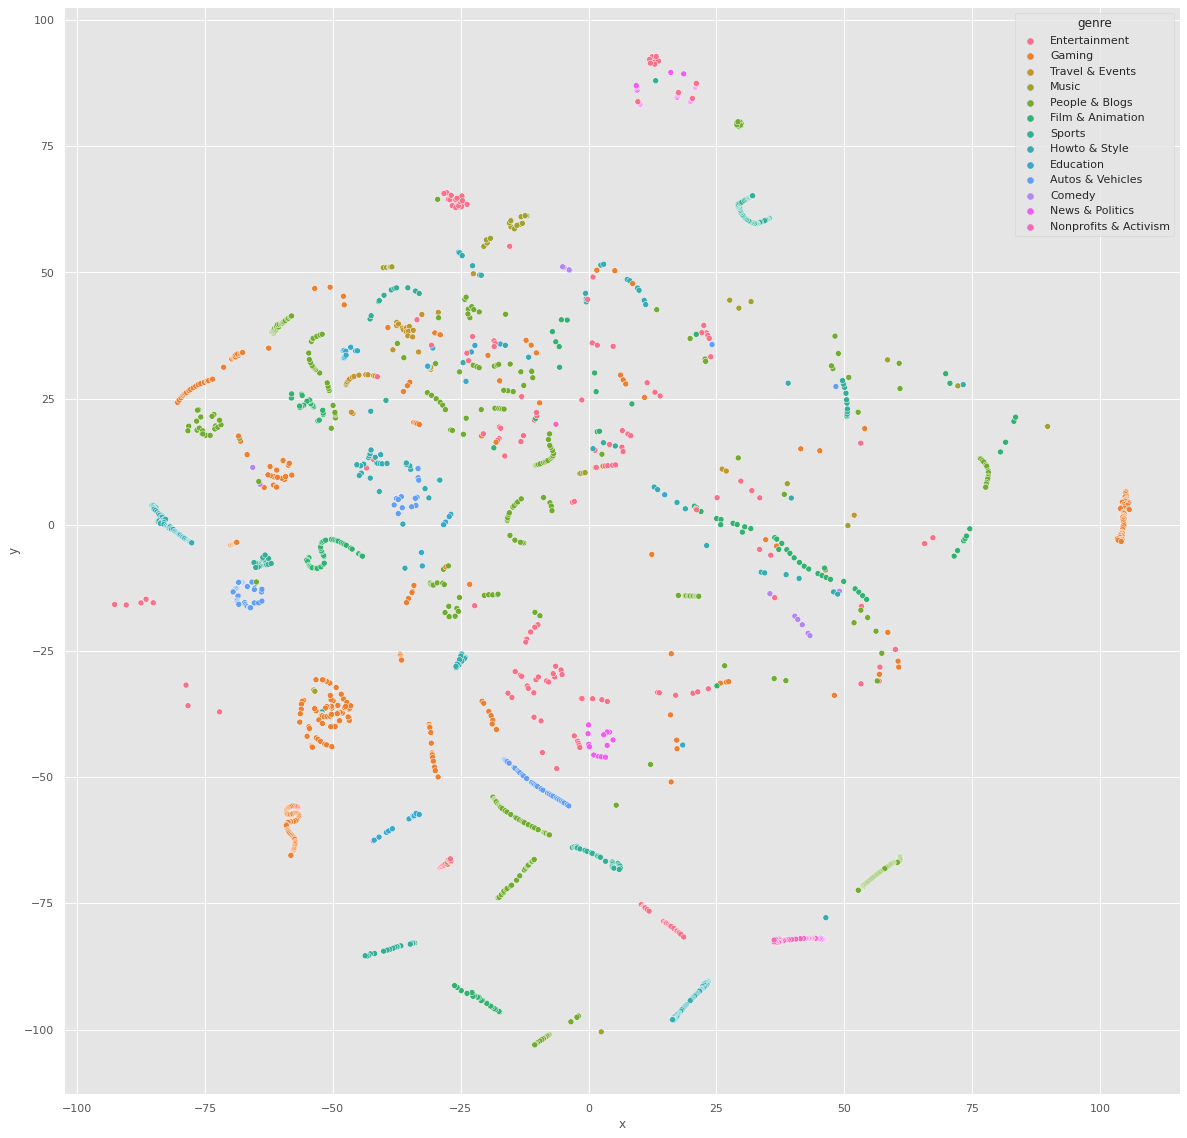

In [237]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['genre'].iloc[:,0])
sns.set(rc={'figure.figsize':(18,15)})

In [ ]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['channel'].iloc[:,0])
sns.set(rc={'figure.figsize':(18,15)})

In [285]:
data_train32['샘플개수']

0     60~무한
1     60~무한
2     60~무한
3     60~무한
4     60~무한
      ...  
10    0~15개
11    0~15개
12    0~15개
13    0~15개
14    0~15개
Name: 샘플개수, Length: 9190, dtype: category
Categories (5, object): ['0~15개' < '15~30개' < '30~45개' < '45~60개' < '60~무한']

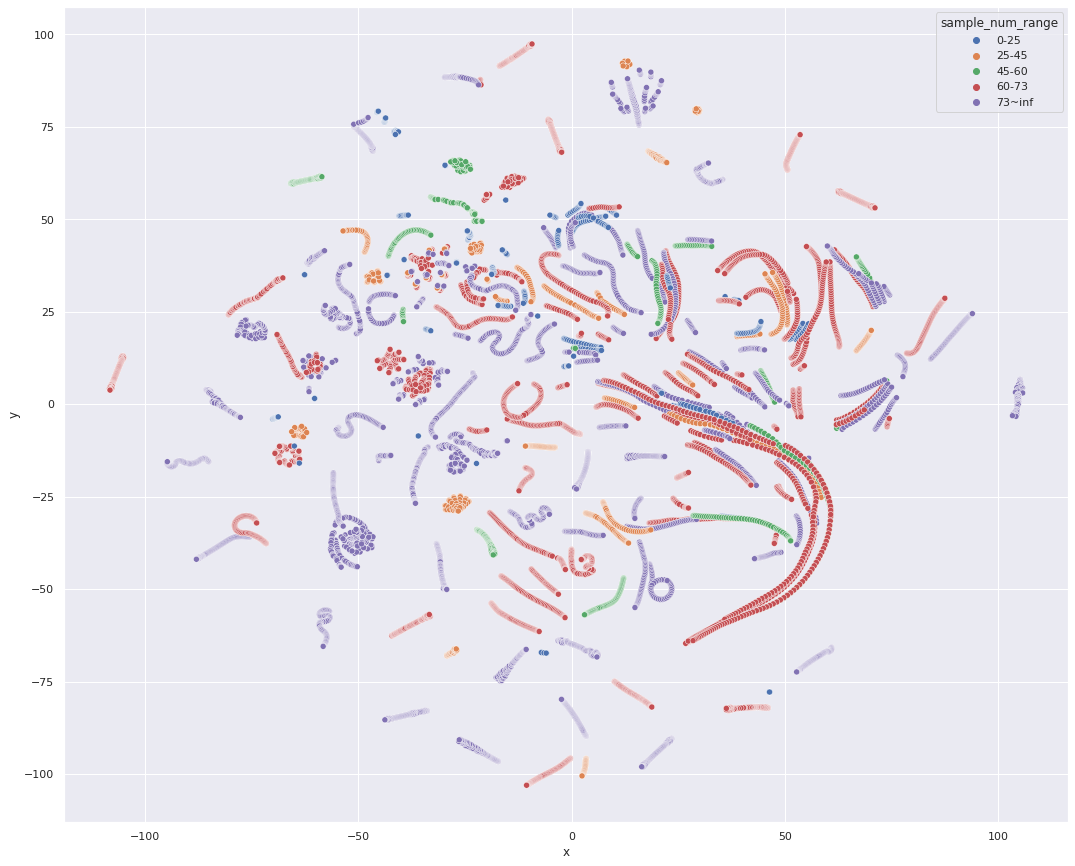

In [292]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['sample_num_range'])
sns.set(rc={'figure.figsize':(18,15)})

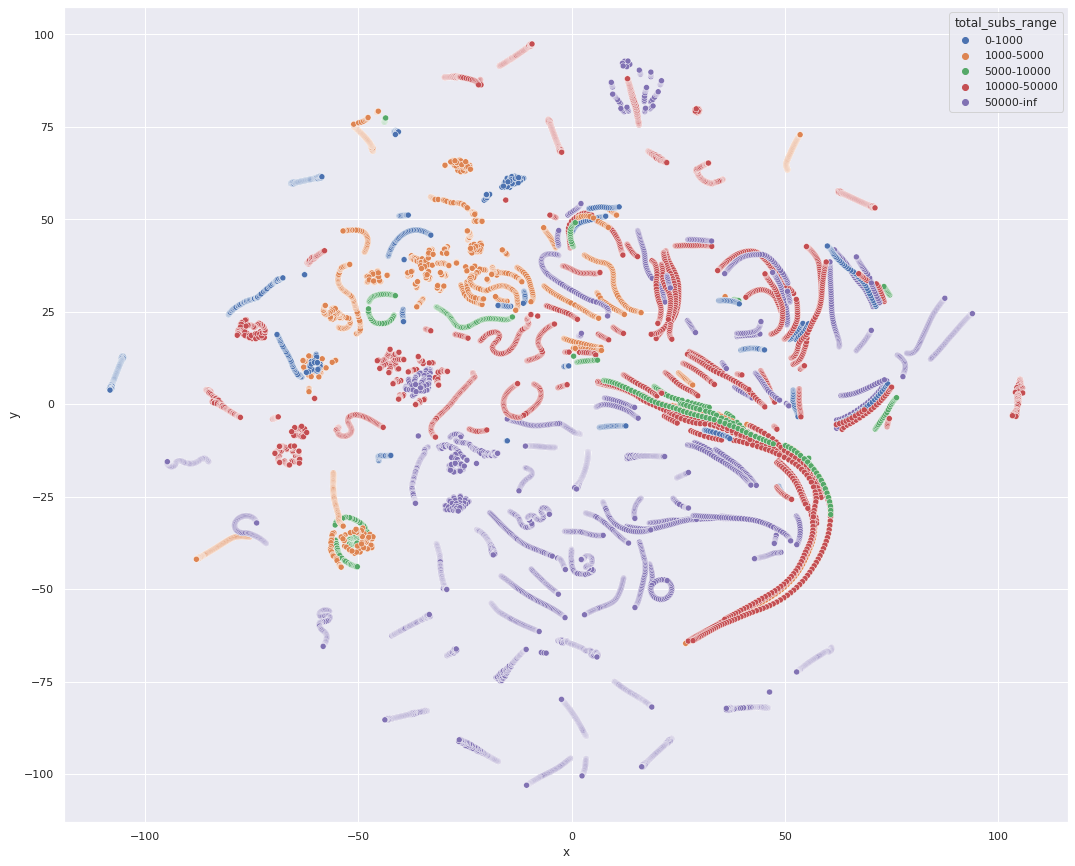

In [310]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['total_subs_range'])
sns.set(rc={'figure.figsize':(18,15)})

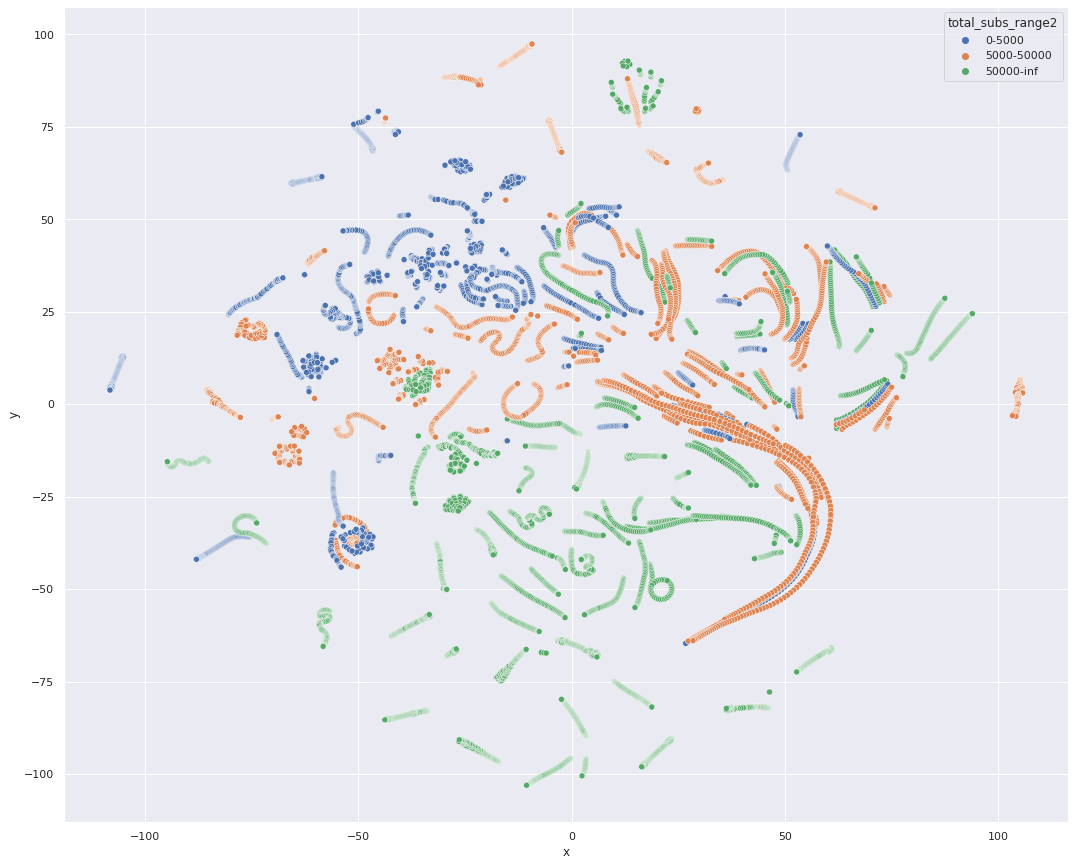

In [359]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['total_subs_range2'])
sns.set(rc={'figure.figsize':(18,15)})

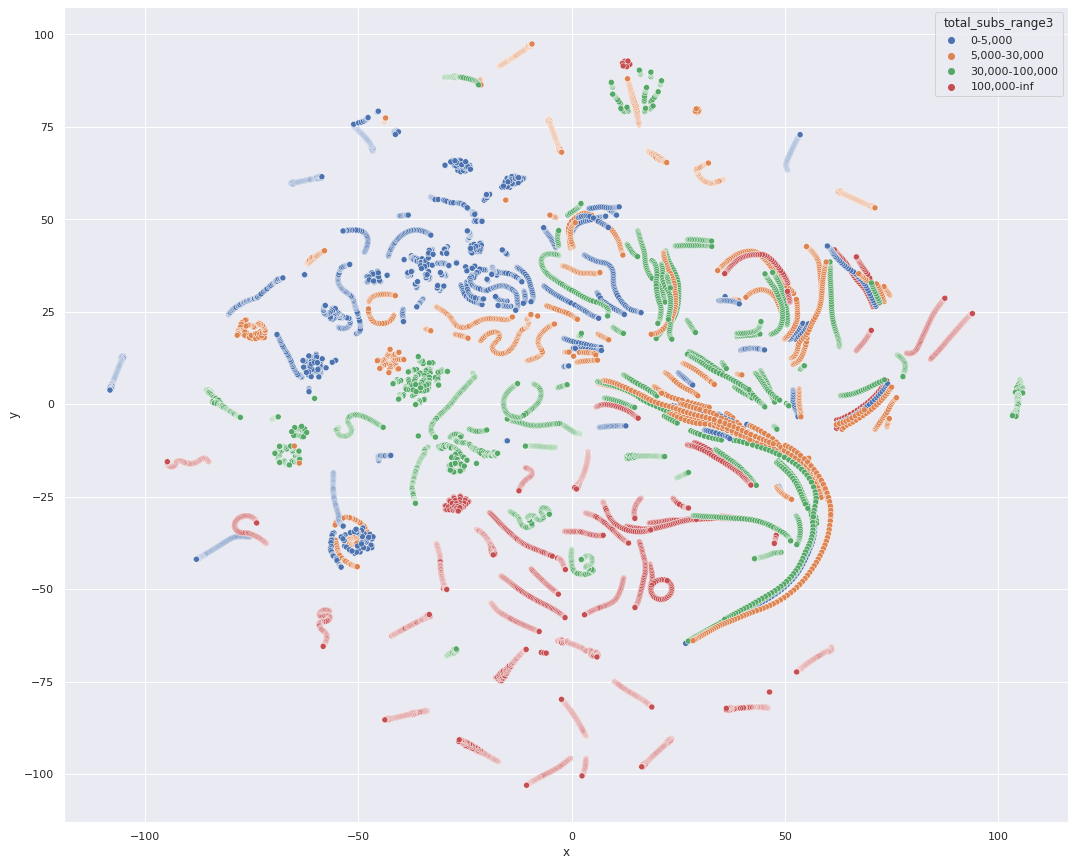

In [361]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['total_subs_range3'])
sns.set(rc={'figure.figsize':(18,15)})

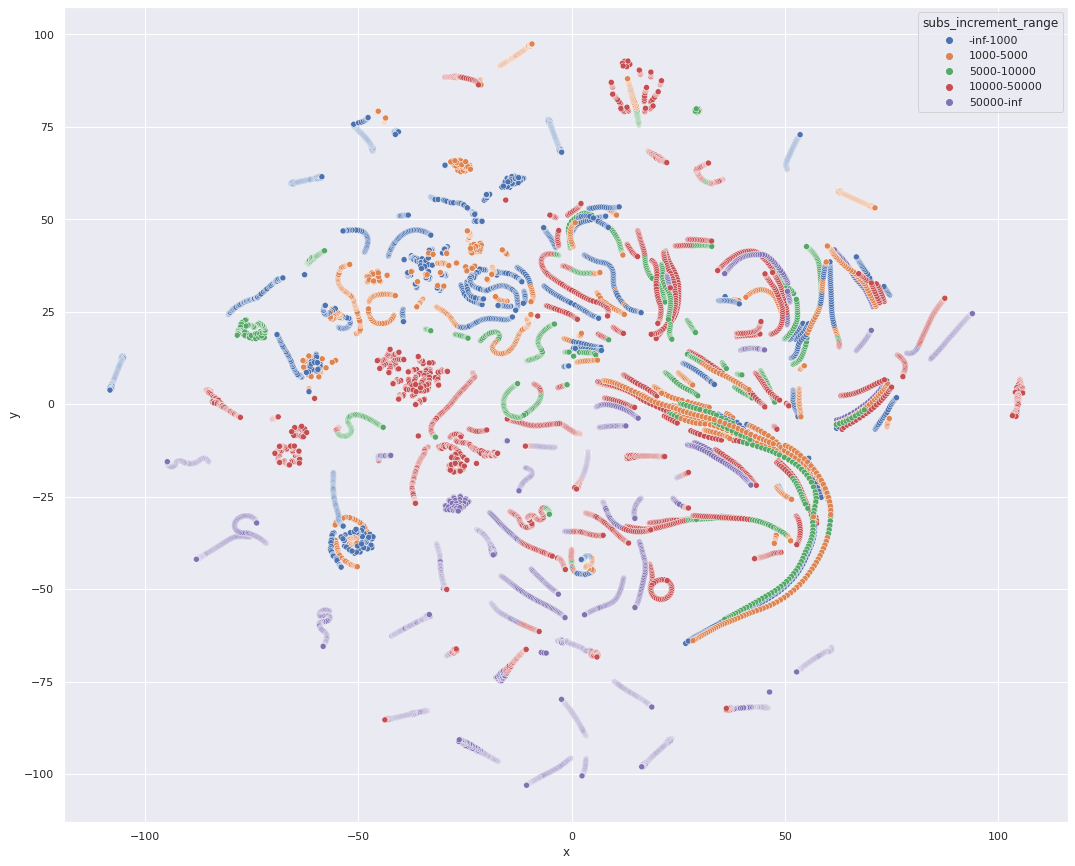

In [356]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['subs_increment_range'])
sns.set(rc={'figure.figsize':(18,15)})

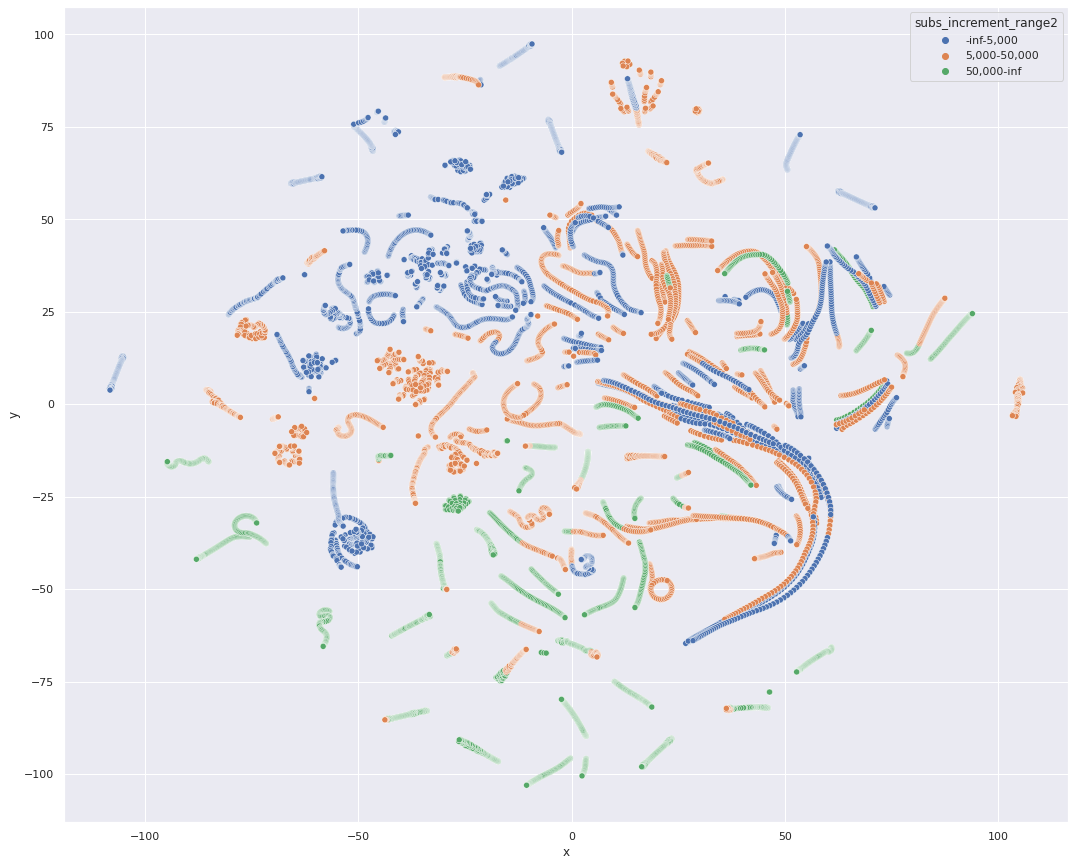

In [377]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['subs_increment_range2'])
sns.set(rc={'figure.figsize':(18,15)})

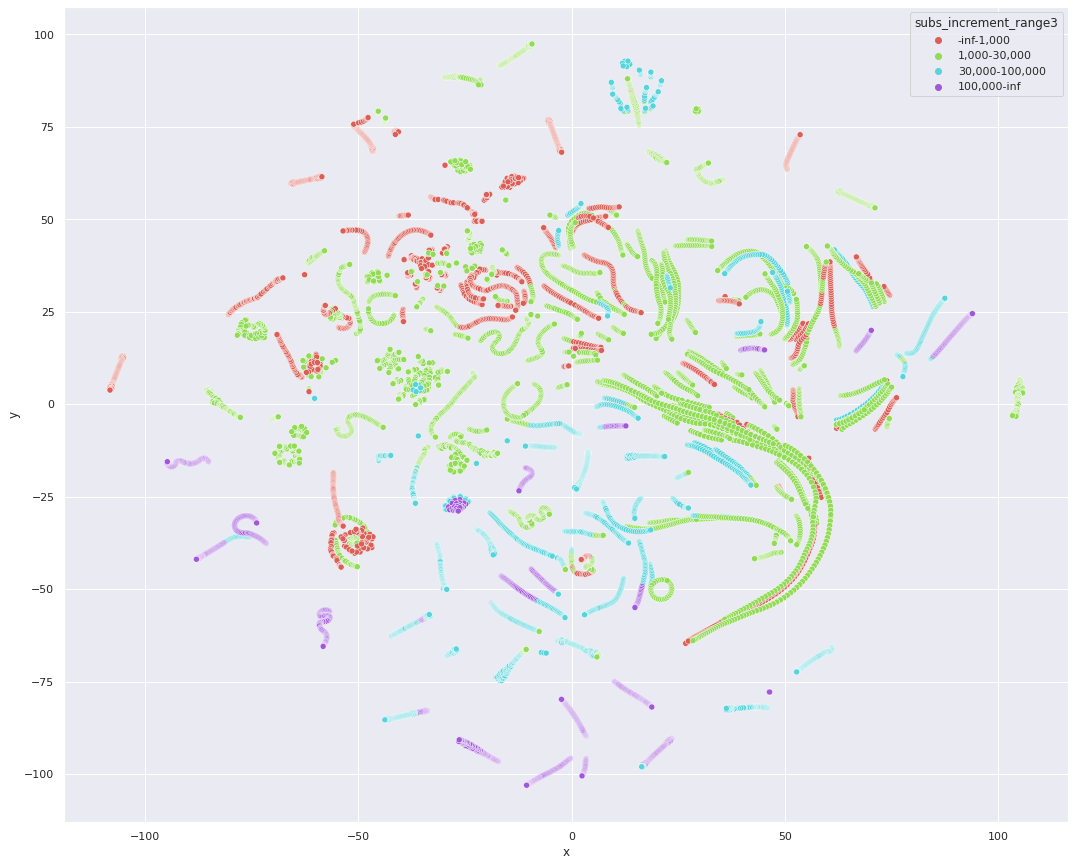

In [385]:
sns.scatterplot(data=data_train32, x='x', y='y', hue=data_train32['subs_increment_range3'], palette='hls')
sns.set(rc={'figure.figsize':(18,15)})

#### lite_path_모델과 feature 맞추기

In [205]:
# 데이터 로드하기
filter_size=180
target_size=7
stride=1
drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
                 'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
target_features = ['sub_diff']

data_train, data_label = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=True)


In [258]:
def stack_to_multi(df):
    feature_num=len(set(df.columns))
    window_num=int(df.shape[1]/feature_num)
    sample_num=int(df.shape[0])
    temp=np.empty([sample_num,window_num,feature_num])
    for i in range(feature_num):
        temp[:,:,i]=df.iloc[:,window_num*i:window_num*i+window_num]
    
    return temp
    

In [259]:
data_train=stack_to_multi(data_train)

In [260]:
print(data_train.shape)
print(data_label.shape)

(3614, 180, 4)
(3614, 7)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def fit_3d(x_train,x_val,x_test):
    x_train_sample = x_train.shape[0] #샘플 개수
    x_val_sample=x_val.shape[0]
    x_test_sample=x_test.shape[0]
    
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1,results2,results3=([],[],[])
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))
        results2.append(scaler.transform(x_val[:,ss,:]).reshape(x_val_sample,1,x_feature))
        results3.append(scaler.transform(x_test[:,ss,:]).reshape(x_test_sample,1,x_feature))
    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    df_val_scaled=np.concatenate(results2,axis=1)
    df_test_scaled=np.concatenate(results3,axis=1)
    
    return df_train_scaled,df_val_scaled,df_test_scaled

In [ ]:
x_train_copy,x_val_copy,x_test_copy=fit_3d(x_train,x_val,x_test)

In [ ]:
y_train_copy=scaler_y.fit_transform(y_train)
y_val_copy=scaler_y.transform(y_val)
y_test_copy=scaler_y.transform(y_test)


In [ ]:
print("x_train_copy's shape: ", x_train_copy.shape) 
print("y_train_copy's shape: ", y_train_copy.shape) 
print("x_val_copy's shape: ", x_val_copy.shape)
print("y_val_copy's shape: ", y_val_copy.shape)
print("x_test_copy's shape: ", x_test_copy.shape)
print("y_test_copy's shape: ", y_test_copy.shape)

In [ ]:
# 텐서 슬라이스로 변형하기
import tensorflow as tf

BATCH_SIZE = 64

train_data = tf.data.Dataset.from_tensor_slices((x_train_copy, y_train_copy))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val_copy, y_val_copy))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [206]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

> scale 후의 data를 이용

In [207]:
scaler=MinMaxScaler()
scaled_train_data=scaler.fit_transform(data_train)

> 1482개의 data, 2160개의 column(time-series)

In [208]:
scaled_train_data.shape

(3614, 720)

In [209]:
pca=PCA(n_components=50) # 50d까지.
reducted_50d=pca.fit_transform(scaled_train_data)

In [210]:
reducted_3d=TSNE(n_components=3).fit_transform(reducted_50d)

In [211]:
x,y,z=reducted_3d[:,0], reducted_3d[:,1], reducted_3d[:,2]

In [225]:
for_kmeans=np.array([x,y,z]).T

In [226]:
for_kmeans.shape

(3614, 3)

In [213]:
scaled_train_data

array([[0.72177994, 0.51048149, 0.57512602, ..., 0.19254658, 0.19254658,
        0.19254658],
       [0.51048149, 0.57512602, 0.74656701, ..., 0.19254658, 0.19254658,
        0.19254658],
       [0.57512602, 0.74656701, 0.6875717 , ..., 0.19254658, 0.19254658,
        0.37888199],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00931677, 0.01242236,
        0.01242236],
       [0.        , 0.        , 0.04926125, ..., 0.01242236, 0.01242236,
        0.01863354],
       [0.        , 0.04926125, 0.04630627, ..., 0.01242236, 0.01863354,
        0.01863354]])

In [228]:
model=KMeans(n_clusters=5,algorithm='auto')
model.fit(for_kmeans)
predict=pd.DataFrame(model.predict(for_kmeans))
predict.columns=['predict']

In [ ]:
print(predict.shape, scaled_train_data.shape)
predict.value_counts()


In [218]:
original=pd.DataFrame(scaled_train_data)


In [229]:
original['k-means']=predict.values

In [234]:
original['k-means']

0       4
1       4
2       4
3       4
4       4
       ..
3609    3
3610    3
3611    3
3612    3
3613    3
Name: k-means, Length: 3614, dtype: int32

#### 1. random_state하게 나눈 경우(다른파일)

#### 2.계층별샘플링을 한 경우

In [251]:
original

0         1         2         3         4         5         6  \
0     0.721780  0.510481  0.575126  0.746567  0.687572  0.797236  0.711072   
1     0.510481  0.575126  0.746567  0.687572  0.797236  0.711072  0.336311   
2     0.575126  0.746567  0.687572  0.797236  0.711072  0.336311  0.624770   
3     0.746567  0.687572  0.797236  0.711072  0.336311  0.624770  0.369425   
4     0.687572  0.797236  0.711072  0.336311  0.624770  0.369425  0.656301   
...        ...       ...       ...       ...       ...       ...       ...   
3609  0.000000  0.000000  0.000000  0.000000  0.000000  0.049261  0.046306   
3610  0.000000  0.000000  0.000000  0.000000  0.049261  0.046306  0.000000   
3611  0.000000  0.000000  0.000000  0.049261  0.046306  0.000000  0.000000   
3612  0.000000  0.000000  0.049261  0.046306  0.000000  0.000000  0.000000   
3613  0.000000  0.049261  0.046306  0.000000  0.000000  0.000000  0.000000   

             7         8         9  ...       711       712       713  \
0     0.336311  0.624770  0.369425  ...  0.192547  0.068323  0.316770   
1     0.624770  0.369425  0.656301  ...  0.068323  0.316770  0.316770   
2     0.369425  0.656301  0.475769  ...  0.316770  0.316770  0.378882   
3     0.656301  0.475769  0.621183  ...  0.316770  0.378882  0.316770   
4     0.475769  0.621183  0.467799  ...  0.378882  0.316770  0.192547   
...        ...       ...       ...  ...       ...       ...       ...   
3609  0.000000  0.000000  0.000000  ...  0.006211  0.012422  0.006211   
3610  0.000000  0.000000  0.000000  ...  0.012422  0.006211  0.009317   
3611  0.000000  0.000000  0.000000  ...  0.006211  0.009317  0.009317   
3612  0.000000  0.000000  0.066539  ...  0.009317  0.009317  0.009317   
3613  0.000000  0.066539  0.000000  ...  0.009317  0.009317  0.009317   

           714       715       716       717       718       719  k-means  
0     0.316770  0.378882  0.316770  0.192547  0.192547  0.192547        4  
1     0.378882  0.316770  0.192547  0.192547  0.192547  0.192547        4  
2     0.316770  0.192547  0.192547  0.192547  0.192547  0.378882        4  
3     0.192547  0.192547  0.192547  0.192547  0.378882  0.192547        4  
4     0.192547  0.192547  0.192547  0.378882  0.192547  0.192547        4  
...        ...       ...       ...       ...       ...       ...      ...  
3609  0.009317  0.009317  0.009317  0.009317  0.009317  0.009317        3  
3610  0.009317  0.009317  0.009317  0.009317  0.009317  0.012422        3  
3611  0.009317  0.009317  0.009317  0.009317  0.012422  0.012422        3  
3612  0.009317  0.009317  0.009317  0.012422  0.012422  0.018634        3  
3613  0.009317  0.009317  0.012422  0.012422  0.018634  0.018634        3  

[3614 rows x 721 columns]

In [241]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=7)
for train_index, test_index in split.split(original, original['k-means']):
    strat_train_set=original.loc[train_index]
    strat_valid_set=original.loc[test_index]

In [242]:
print(strat_train_set.shape,strat_valid_set.shape)

(2529, 721) (1085, 721)


In [243]:
print(type(strat_train_set))

<class 'pandas.core.frame.DataFrame'>


In [248]:
strat_valid_set

0    1         2         3         4         5         6  \
3340  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
704   0.01036  0.0  0.000000  0.011020  0.032157  0.000000  0.017139   
952   0.00000  0.0  0.175317  0.208587  0.452564  0.000000  0.000000   
829   0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1259  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.314375   
...       ...  ...       ...       ...       ...       ...       ...   
2306  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2649  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1959  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3423  0.00000  0.0  0.000000  0.000000  0.000000  0.194507  0.000000   
2951  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

             7         8         9  ...       711       712       713  \
3340  0.000000  0.000000  0.000000  ...  0.006273  0.006335  0.006273   
704   0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
952   0.193569  0.199618  0.184252  ...  0.015528  0.015528  0.006211   
829   0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
1259  0.102312  0.000000  0.000000  ...  0.006211  0.012422  0.012422   
...        ...       ...       ...  ...       ...       ...       ...   
2306  0.000000  0.000000  0.000000  ...  0.068323  0.037267  0.037267   
2649  0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
1959  0.047175  0.000000  0.000000  ...  0.012422  0.012422  0.012422   
3423  0.000000  0.029133  0.000000  ...  0.012360  0.006211  0.012484   
2951  0.000000  0.000000  0.000000  ...  0.012422  0.006211  0.012422   

           714       715       716       717       718       719  k-means  
3340  0.006335  0.006335  0.006273  0.006273  0.006273  0.006335        2  
704   0.006211  0.006211  0.006211  0.006211  0.006211  0.006211        2  
952   0.062112  0.006211  0.012422  0.012422  0.009317  0.009317        1  
829   0.006211  0.006211  0.006211  0.031056  0.031056  0.006211        1  
1259  0.012422  0.012422  0.012422  0.012422  0.012422  0.012422        3  
...        ...       ...       ...       ...       ...       ...      ...  
2306  0.006211  0.068323  0.006211  0.006211  0.006211  0.068323        3  
2649  0.006211  0.006211  0.006211  0.006211  0.006211  0.006211        2  
1959  0.012422  0.018634  0.037267  0.043478  0.040373  0.040373        4  
3423  0.006211  0.012422  0.006211  0.012422  0.012422  0.012422        3  
2951  0.012422  0.006211  0.012422  0.012422  0.006211  0.006211        1  

[1085 rows x 721 columns]

In [255]:
strat_valid_set.reset_index(drop=True)

0    1         2         3         4         5         6  \
0     0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.01036  0.0  0.000000  0.011020  0.032157  0.000000  0.017139   
2     0.00000  0.0  0.175317  0.208587  0.452564  0.000000  0.000000   
3     0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.314375   
...       ...  ...       ...       ...       ...       ...       ...   
1080  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1081  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1082  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1083  0.00000  0.0  0.000000  0.000000  0.000000  0.194507  0.000000   
1084  0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

             7         8         9  ...       711       712       713  \
0     0.000000  0.000000  0.000000  ...  0.006273  0.006335  0.006273   
1     0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
2     0.193569  0.199618  0.184252  ...  0.015528  0.015528  0.006211   
3     0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
4     0.102312  0.000000  0.000000  ...  0.006211  0.012422  0.012422   
...        ...       ...       ...  ...       ...       ...       ...   
1080  0.000000  0.000000  0.000000  ...  0.068323  0.037267  0.037267   
1081  0.000000  0.000000  0.000000  ...  0.006211  0.006211  0.006211   
1082  0.047175  0.000000  0.000000  ...  0.012422  0.012422  0.012422   
1083  0.000000  0.029133  0.000000  ...  0.012360  0.006211  0.012484   
1084  0.000000  0.000000  0.000000  ...  0.012422  0.006211  0.012422   

           714       715       716       717       718       719  k-means  
0     0.006335  0.006335  0.006273  0.006273  0.006273  0.006335        2  
1     0.006211  0.006211  0.006211  0.006211  0.006211  0.006211        2  
2     0.062112  0.006211  0.012422  0.012422  0.009317  0.009317        1  
3     0.006211  0.006211  0.006211  0.031056  0.031056  0.006211        1  
4     0.012422  0.012422  0.012422  0.012422  0.012422  0.012422        3  
...        ...       ...       ...       ...       ...       ...      ...  
1080  0.006211  0.068323  0.006211  0.006211  0.006211  0.068323        3  
1081  0.006211  0.006211  0.006211  0.006211  0.006211  0.006211        2  
1082  0.012422  0.018634  0.037267  0.043478  0.040373  0.040373        4  
1083  0.006211  0.012422  0.006211  0.012422  0.012422  0.012422        3  
1084  0.012422  0.006211  0.012422  0.012422  0.006211  0.006211        1  

[1085 rows x 721 columns]

In [256]:
strat_valid_set=strat_valid_set.reset_index(drop=True)

In [257]:
split2=StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=7)
for train_index, test_index in split2.split(strat_valid_set, strat_valid_set['k-means']):
    strat_valid_set3=strat_valid_set.loc[train_index]
    strat_test_set3=strat_valid_set.loc[test_index]

In [ ]:
model=KMeans(n_clusters=4,algorithm='auto')
model.fit(scaled_train_data)
predict=pd.DataFrame(model.predict(scaled_train_data))
predict.columns=['predict']

predict.shape

scaled_train_data.shape

predict.value_counts()

In [26]:
model=KMeans(n_clusters=4,algorithm='auto')
model.fit(scaled_train_data)
predict=pd.DataFrame(model.predict(scaled_train_data))
predict.columns=['predict']

In [31]:
predict.shape

(1482, 1)

In [32]:
scaled_train_data.shape

(1482, 2160)

In [63]:
predict.value_counts()

predict
0          1076
2           248
1            83
3            75
dtype: int64

#### lite_path

> Windowsize = 180  
target-size = 30  
stirde = 2  
총 data 개수 : 1482개  
총 channel 개수 : 28개

In [204]:
loader=DataLoader(lite_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [38]:
# 데이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
#장르 포함


target_features = ['sub_diff']

data_train, data_label = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


In [39]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

> scale 후의 data를 이용

In [40]:
scaler=MinMaxScaler()
scaled_train_data=scaler.fit_transform(data_train)

> 1482개의 data, 2160개의 column(time-series)

In [41]:
scaled_train_data.shape

(1482, 2160)

In [42]:
pca=PCA(n_components=50) # 50d까지.
reducted_50d=pca.fit_transform(scaled_train_data)

In [43]:
reducted_2d=TSNE(n_components=2).fit_transform(reducted_50d)

In [44]:
x,y=reducted_2d[:,0], reducted_2d[:,1]

> plotting용 (학습에 쓰이지 않는 feautre또한 포함)

In [119]:
loader2=DataLoader(lite_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [120]:
# 데이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','title', 'description', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
#장르 포함


target_features = ['sub_diff']

data_train2, data_label2 = loader2.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


In [57]:
data_train2

channel          genre    sign_in duration video_n_view n_comment n_like  \
0   2B Gamer  Entertainment  2019-9-27   207.62         9676         2      0   
1   2B Gamer  Entertainment  2019-9-27  165.435      10753.5       0.5      0   
2   2B Gamer  Entertainment  2019-9-27   197.78      17747.5       3.5      0   
3   2B Gamer  Entertainment  2019-9-27   204.54        25302   3.66667      0   
4   2B Gamer  Entertainment  2019-9-27  179.715      20621.5         3      0   
..       ...            ...        ...      ...          ...       ...    ...   
3   こわ動!TOP5            NaN  2019-9-16        0            0         0      0   
4   こわ動!TOP5            NaN  2019-9-16        0            0         0      0   
5   こわ動!TOP5  Entertainment  2019-9-16    16.88       683497       940   4033   
6   こわ動!TOP5            NaN  2019-9-16        0            0         0      0   
7   こわ動!TOP5  Entertainment  2019-9-16    10.65       301677       398   2011   

   n_dislike daily_n_view   cumul_view  ...   n_like n_dislike daily_n_view  \
0          0        10500       679200  ...        0         0       386400   
1          0        25500       741100  ...        0         0       217399   
2          0        91300       857900  ...        0         0       504000   
3          0        91100    1.011e+06  ...  23383.7   458.333       308700   
4          0        58099   1.1556e+06  ...    71632      1272       407000   
..       ...          ...          ...  ...      ...       ...          ...   
3          0        86100       778495  ...        0         0        43500   
4          0        74300       927095  ...     2167        40        78300   
5        224       130100   1.1315e+06  ...        0         0        34900   
6          0       235799  1.50519e+06  ...        0         0        24100   
7         95       235799  1.97679e+06  ...     1960        57        97100   

     cumul_view cumul_subs n_hashtage video_num sub_diff no_upload_interval  \
0   1.70298e+07     275000          4         2     3000                  0   
1   1.75128e+07     284000          3         3     6000                  0   
2   1.82342e+07     290000          3         2     3000                  0   
3   1.91084e+07     300000          2         3     5000                  0   
4   2.00794e+07     310000        1.5         2     5000                  0   
..          ...        ...        ...       ...      ...                ...   
3   1.41181e+07      80000          0         0      100                  2   
4   1.42296e+07      80200          3         1      100                  0   
5   1.42883e+07      80500          0         0      101                  2   
6   1.43734e+07      80700          0         0      100                  1   
7   1.44946e+07      80900          4         1      100                  0   

   K_Means_label  
0              0  
1              0  
2              0  
3              0  
4              0  
..           ...  
3              0  
4              0  
5              0  
6              0  
7              1  

[1482 rows x 2701 columns]

In [58]:
data_train2['x']=reducted_2d[:,0]
data_train2['y']=reducted_2d[:,1]

In [59]:
data_train2['channel'].iloc[:,0].value_counts()

Gabi                                                  76
HANNIBAL TV Officielle                                75
Super Fafa                                            75
Nagma Mirajkar                                        75
2B Gamer                                              75
Idriss J. Aberkane                                    75
ProGuides Teamfight Tactics Comps & TFT Tier Lists    74
Audio RW                                              74
Twin Flame                                            74
WrestleGamia                                          74
Фьючерс                                               74
KeenLevyVEVO                                          73
Colorful Reactions                                    69
Tatiana DeVoe                                         69
The Joker                                             68
410 Gaming                                            63
alexa riley                                           60
E                              

> windowsize가 180일 때, column은 2160개가 된다.

In [60]:
# 채널 개수.
len(set(data_train2['channel'].iloc[:,0].values))

28

> 1. PCA분석으로 1차 차원 축소(2160 to 50 dim)
2. T-SNE으로 2차 축소(50 to 2 dim)

> 산점도

In [46]:
data_train2['genre']

genre          genre          genre          genre          genre  \
0   Entertainment  Entertainment  Entertainment  Entertainment  Entertainment   
1   Entertainment  Entertainment  Entertainment  Entertainment  Entertainment   
2   Entertainment  Entertainment  Entertainment  Entertainment  Entertainment   
3   Entertainment  Entertainment  Entertainment  Entertainment         Gaming   
4   Entertainment  Entertainment         Gaming  Entertainment  Entertainment   
..            ...            ...            ...            ...            ...   
3             NaN  Entertainment            NaN            NaN  Entertainment   
4             NaN            NaN  Entertainment  Entertainment            NaN   
5   Entertainment  Entertainment            NaN            NaN  Entertainment   
6             NaN            NaN  Entertainment            NaN            NaN   
7   Entertainment            NaN            NaN  Entertainment  Entertainment   

            genre          genre          genre          genre          genre  \
0   Entertainment  Entertainment  Entertainment  Entertainment  Entertainment   
1   Entertainment  Entertainment  Entertainment         Gaming  Entertainment   
2   Entertainment         Gaming  Entertainment  Entertainment  Entertainment   
3   Entertainment  Entertainment  Entertainment  Entertainment  Entertainment   
4   Entertainment  Entertainment  Entertainment         Gaming         Gaming   
..            ...            ...            ...            ...            ...   
3   Entertainment            NaN            NaN  Entertainment            NaN   
4             NaN  Entertainment            NaN            NaN  Entertainment   
5             NaN            NaN  Entertainment  Entertainment            NaN   
6   Entertainment  Entertainment            NaN            NaN  Entertainment   
7             NaN            NaN  Entertainment            NaN            NaN   

    ...   genre          genre   genre          genre   genre          genre  \
0   ...  Gaming         Gaming  Gaming         Gaming  Gaming         Gaming   
1   ...  Gaming         Gaming  Gaming         Gaming  Gaming         Gaming   
2   ...  Gaming         Gaming  Gaming         Gaming  Gaming         Gaming   
3   ...  Gaming         Gaming  Gaming         Gaming  Gaming         Gaming   
4   ...  Gaming         Gaming  Gaming         Gaming  Gaming         Gaming   
..  ...     ...            ...     ...            ...     ...            ...   
3   ...     NaN            NaN     NaN  Entertainment     NaN            NaN   
4   ...     NaN  Entertainment     NaN            NaN     NaN  Entertainment   
5   ...     NaN            NaN     NaN  Entertainment     NaN            NaN   
6   ...     NaN  Entertainment     NaN            NaN     NaN  Entertainment   
7   ...     NaN            NaN     NaN  Entertainment     NaN            NaN   

            genre          genre          genre          genre  
0          Gaming         Gaming         Gaming         Gaming  
1          Gaming         Gaming         Gaming         Gaming  
2          Gaming         Gaming         Gaming         Gaming  
3          Gaming         Gaming         Gaming         Gaming  
4          Gaming         Gaming         Gaming         Gaming  
..            ...            ...            ...            ...  
3             NaN  Entertainment            NaN            NaN  
4             NaN            NaN            NaN  Entertainment  
5             NaN  Entertainment            NaN            NaN  
6             NaN            NaN  Entertainment            NaN  
7   Entertainment            NaN            NaN  Entertainment  

[1482 rows x 180 columns]

In [47]:
import seaborn as sns


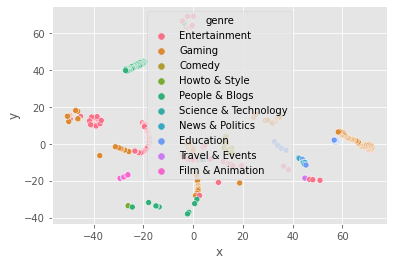

In [61]:
sns.scatterplot(data=data_train2, x='x', y='y', hue=data_train2['genre'].iloc[:,0])
sns.set(rc={'figure.figsize':(18,15)})

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12304 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wh

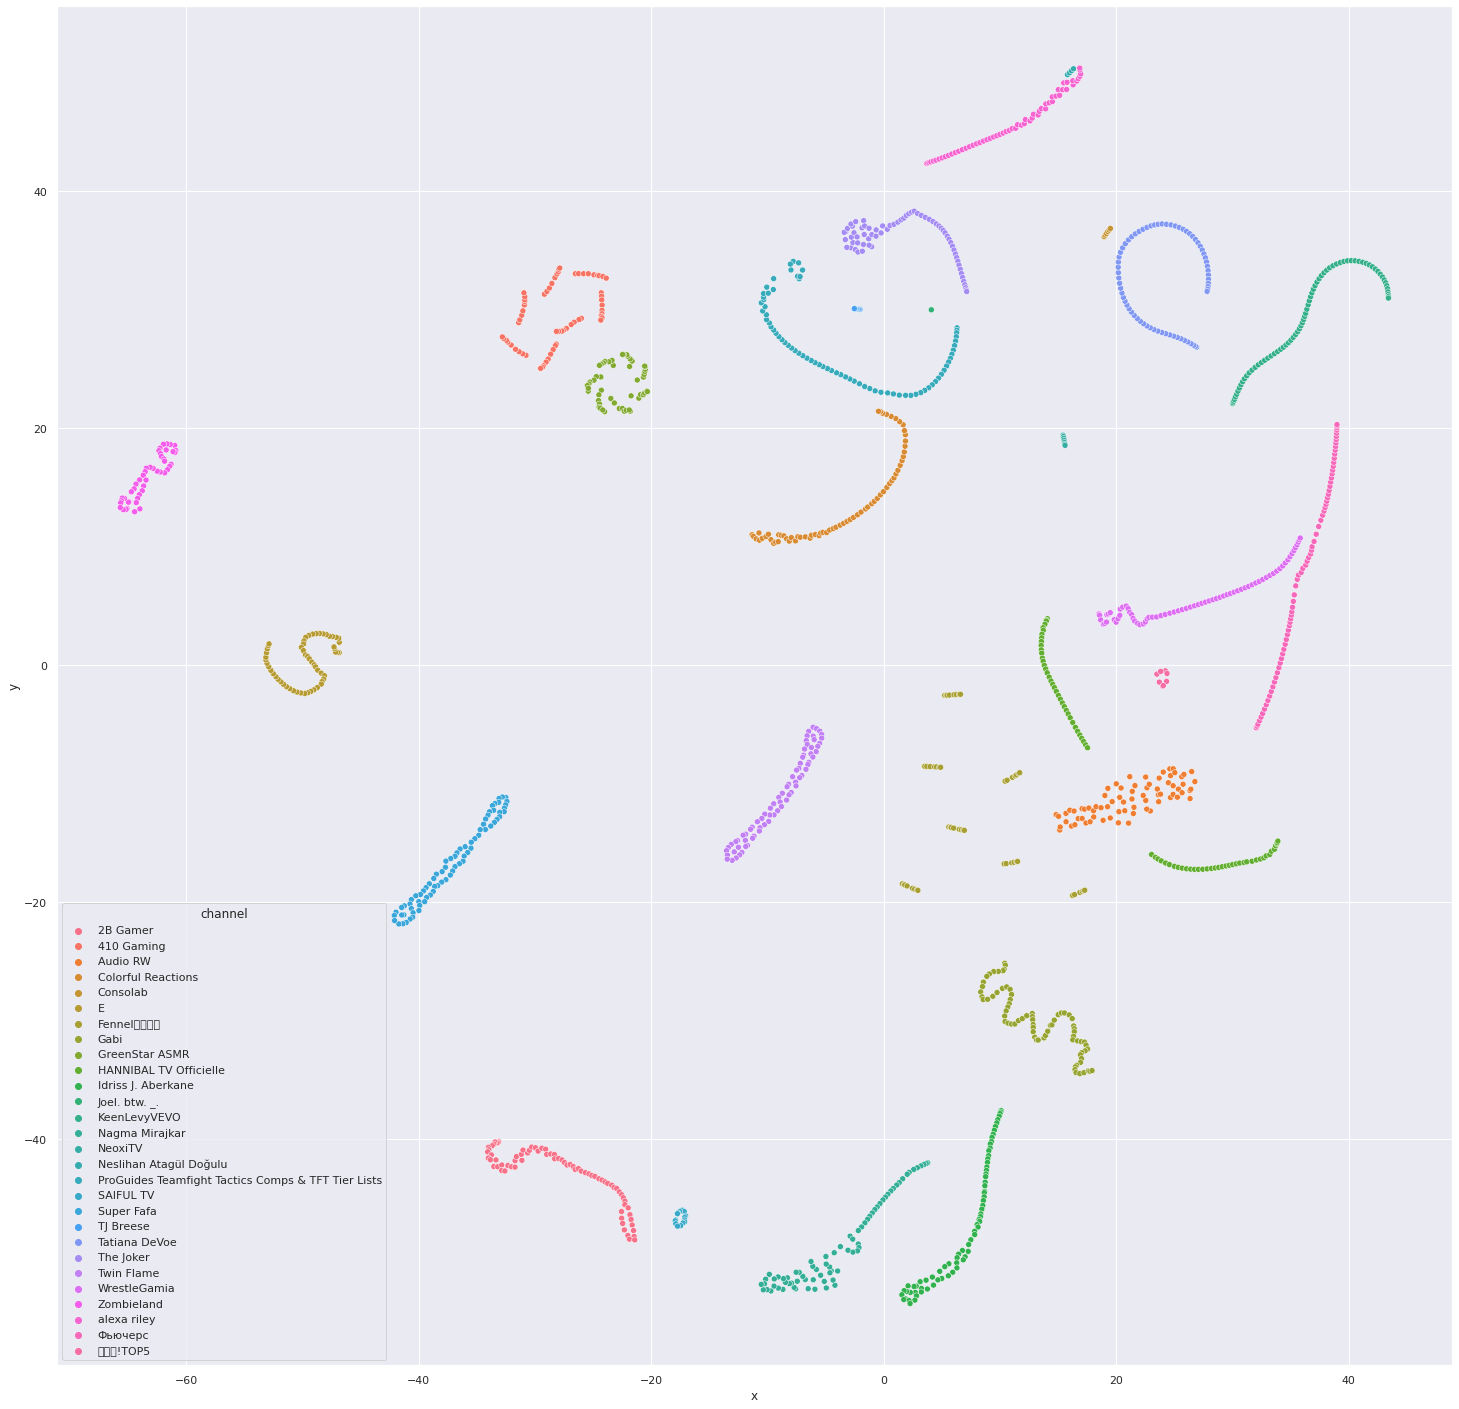

In [182]:
sns.scatterplot(data=data_train2, x='x', y='y', hue=data_train2['channel'].iloc[:,0])
sns.set(rc={'figure.figsize':(20,25)})

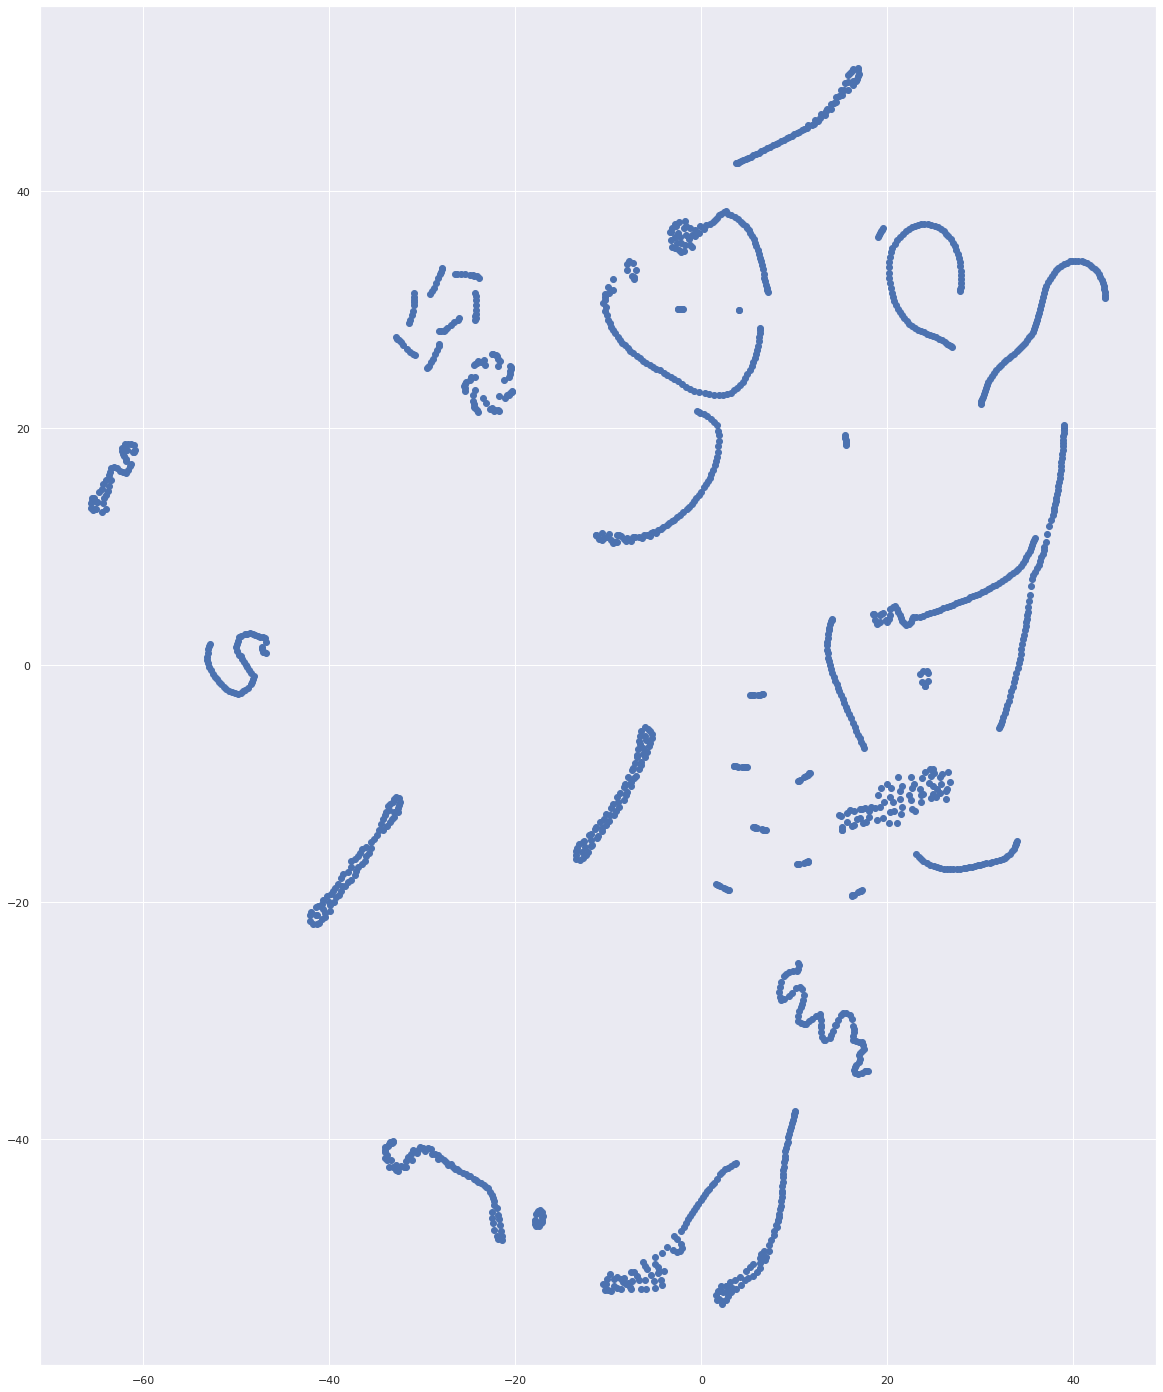

In [183]:
plt.scatter(x,y)

### K-means를 이용한 군집화

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sys



In [8]:
loader4=DataLoader(lite_path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Data Loaded. :P


In [9]:
# 데이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
#장르 포함


target_features = ['sub_diff']

data_train4, data_label4 = loader4.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


> 스케일링

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
scaled_train_data=scaler.fit_transform(data_train4)
scaled_train_data_label=scaler2.fit_transform(data_label4)

In [15]:
scaled_train_data.shape

(1482, 2160)

#### 적정 군집수 판단(inertia value)

In [18]:
ks=range(1,10)
inertias =[]

for k in ks:
    model=KMeans(n_clusters=k)
    model.fit(scaled_train_data)
    inertias.append(model.inertia_)
    

Text(0.5, 1.0, 'Best number of Cluster')

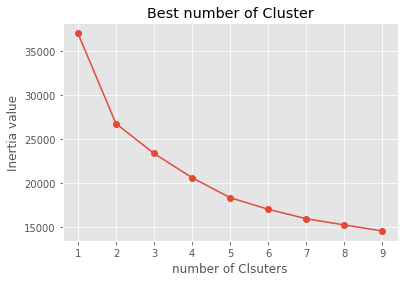

In [24]:
plt.plot(ks,inertias,'-o')
plt.xlabel('number of Clsuters')
plt.ylabel('Inertia value')
plt.xticks(ks)
plt.title('Best number of Cluster')

In [ ]:
# 4개로 진행하자.

#### 클러스터링 진행(4개)

In [26]:
model=KMeans(n_clusters=4,algorithm='auto')
model.fit(scaled_train_data)
predict=pd.DataFrame(model.predict(scaled_train_data))
predict.columns=['predict']

In [31]:
predict.shape

(1482, 1)

In [32]:
scaled_train_data.shape

(1482, 2160)

In [63]:
predict.value_counts()

predict
0          1076
2           248
1            83
3            75
dtype: int64

In [49]:
data_train2.shape

(1482, 2700)

In [50]:
print(x.shape)
print(y.shape)

(1482,)
(1482,)


In [74]:
predict

predict
0           0
1           0
2           0
3           0
4           0
...       ...
1477        0
1478        0
1479        0
1480        0
1481        0

[1482 rows x 1 columns]

In [68]:
data_train2['K_Means_label'].value_counts()

1    1294
0     188
Name: K_Means_label, dtype: int64

In [75]:
data_train2['K_Means_label']=predict.values

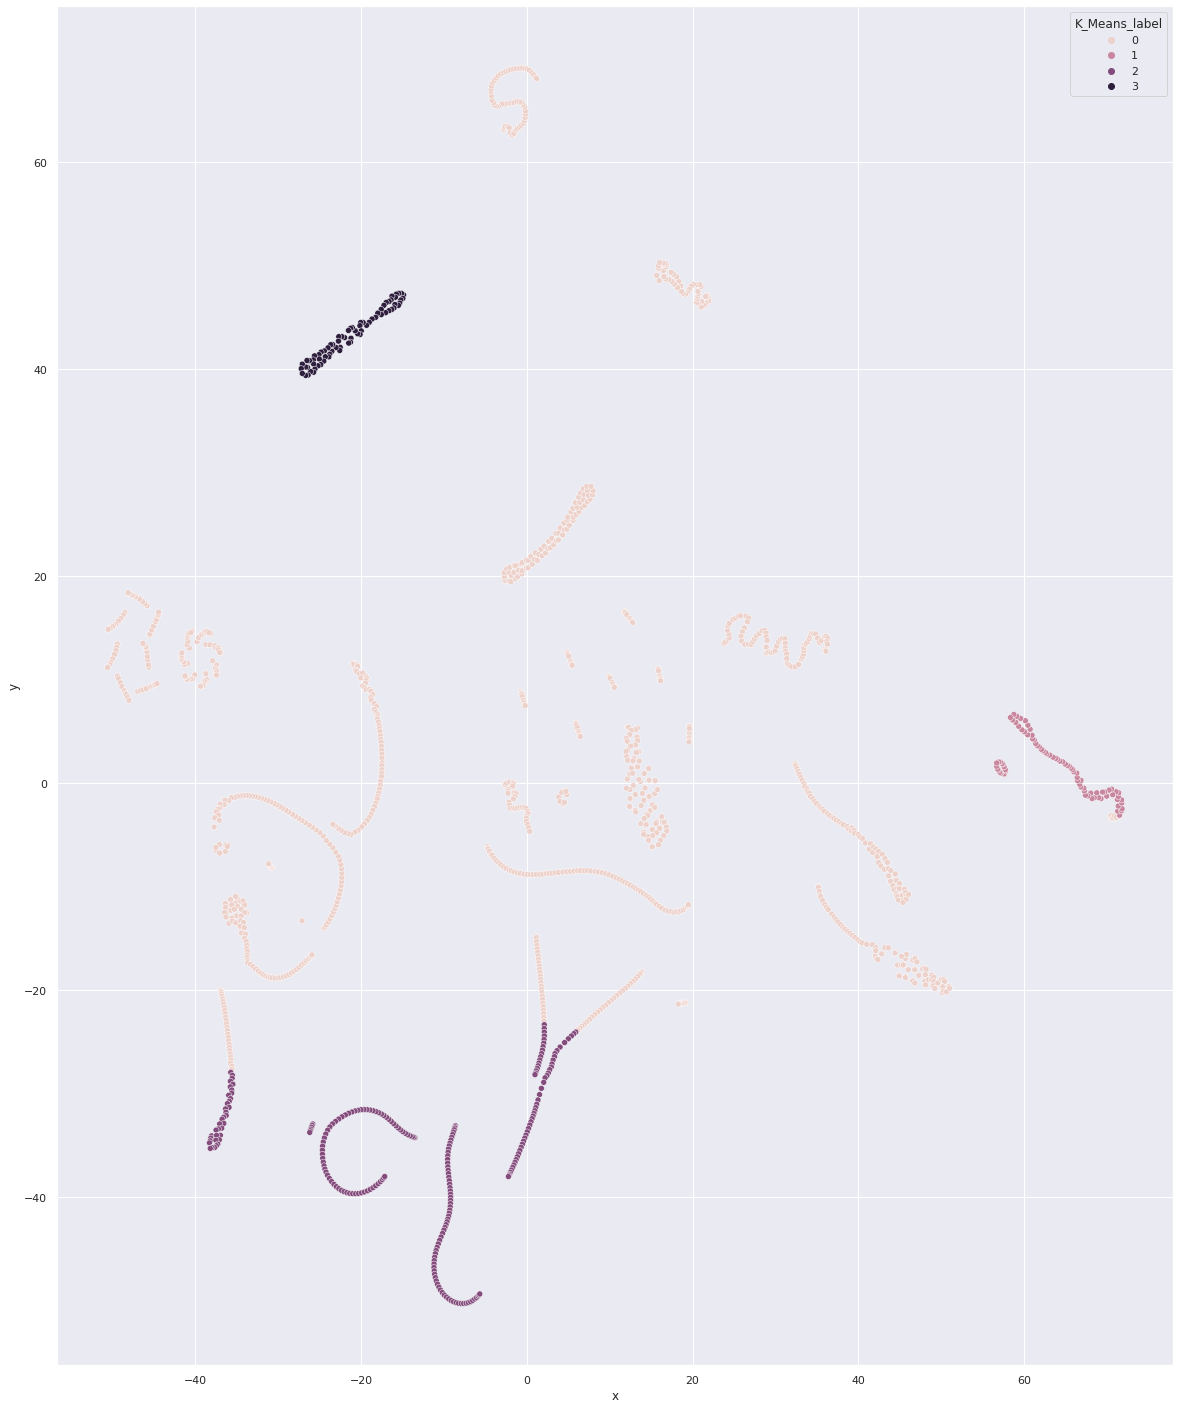

In [76]:
sns.scatterplot(data=data_train2,x='x', y='y',hue='K_Means_label')
sns.set(rc={'figure.figsize':(20,25)})

> 클러스터링 진행(8개)

In [77]:
model=KMeans(n_clusters=8,algorithm='auto')
model.fit(scaled_train_data)
predict=pd.DataFrame(model.predict(scaled_train_data))
predict.columns=['predict']

In [79]:
data_train2['K_Means_8']=predict.values

<AxesSubplot:xlabel='x', ylabel='y'>

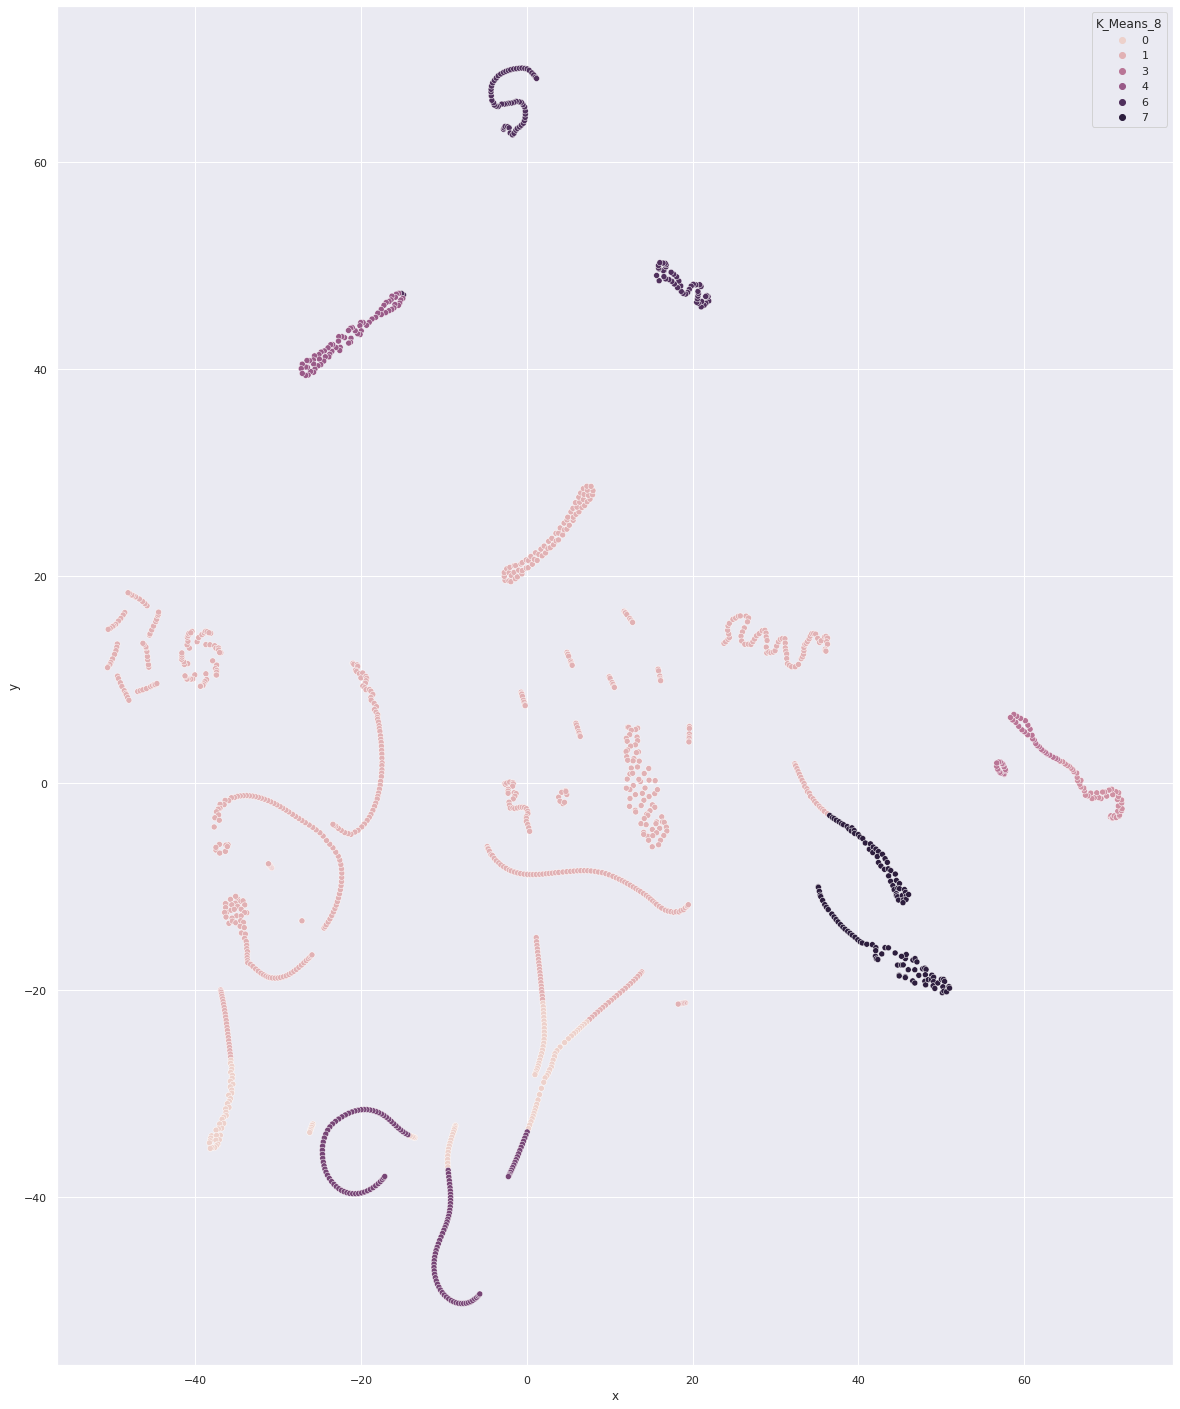

In [80]:
sns.scatterplot(data=data_train2,x='x', y='y', hue='K_Means_8')

### full_data에 대한 K_Means Clustering

In [6]:
# 데z이터 로드하기
filter_size=180
target_size=30
stride=2
# drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
#                  'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
drop_features = ['date','genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
#장르 포함


target_features = ['sub_diff']

data_train, data_label = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=False)


In [112]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

In [ ]:
model_full=KMeans(n_clusters=4,algorithm='auto')
model_full.fit(scaled_train_data3) #full_data

In [105]:
predict_full=pd.DataFrame(model_full.predict(scaled_train_data3))
predict_full.columns=['predict_full']

In [195]:
predict_full.value_counts()

predict_full
0               6447
3               2066
1                379
2                298
dtype: int64

In [107]:
data_train32['K_Means_4']=predict_full.values

<AxesSubplot:xlabel='x', ylabel='y'>

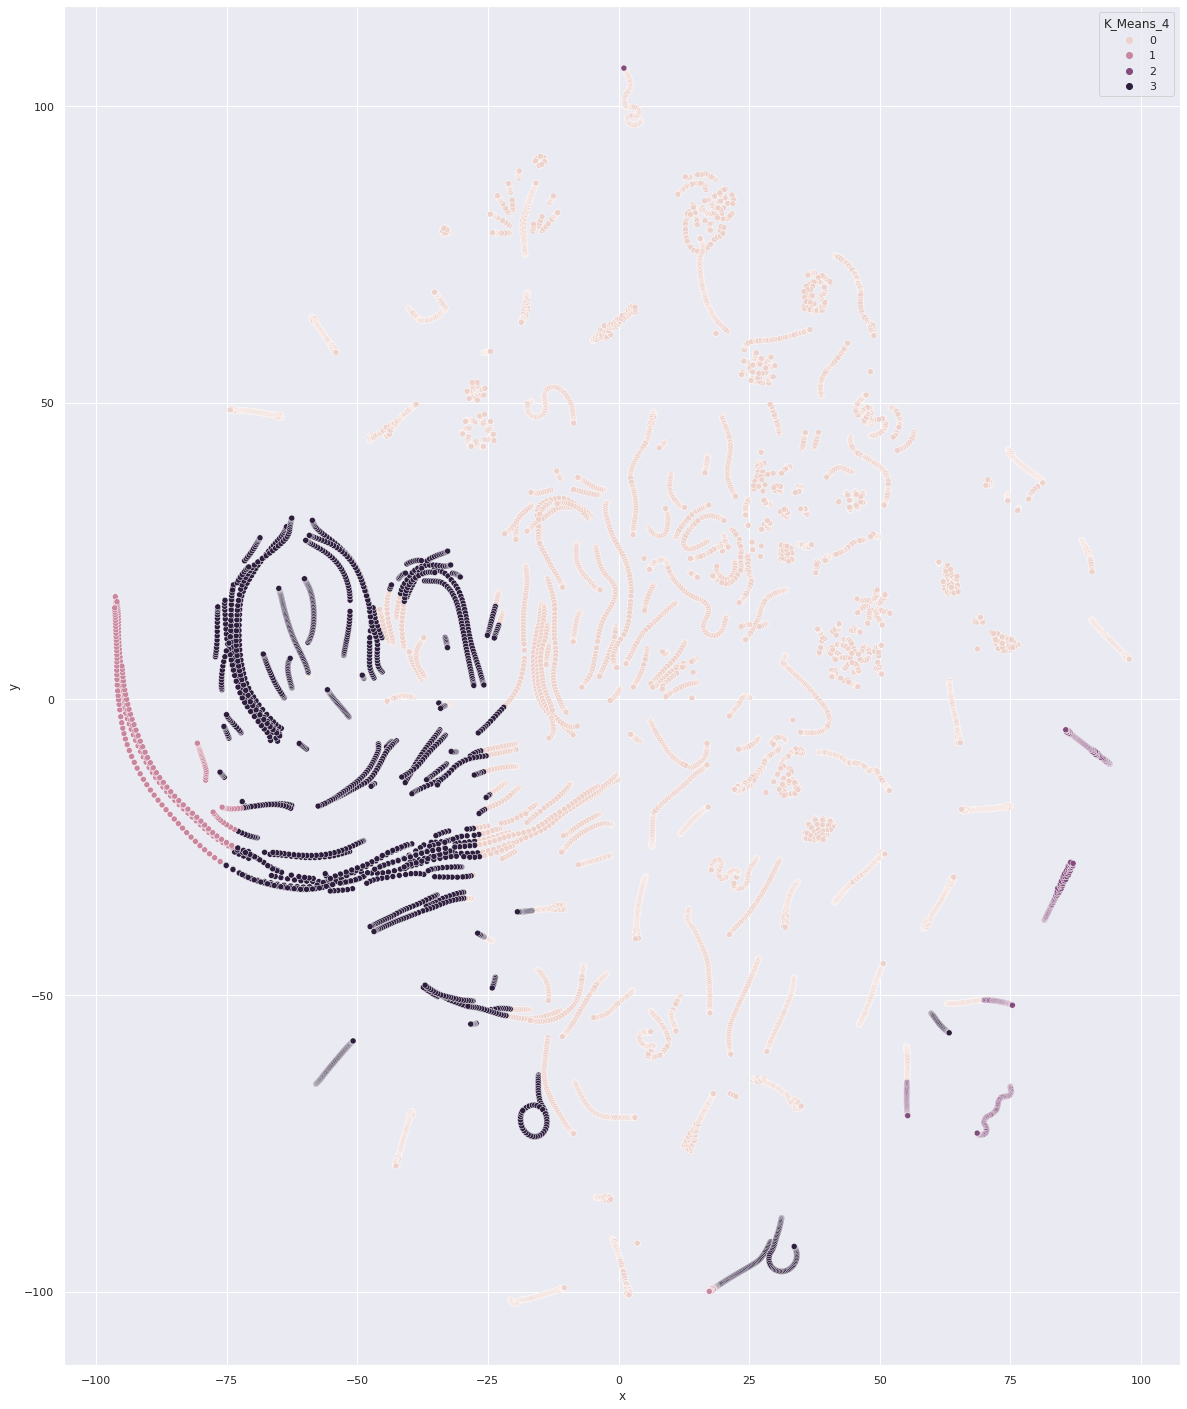

In [108]:
sns.scatterplot(data=data_train32,x='x', y='y', hue='K_Means_4')

## PCA->T-SNE을 통해 3차원으로 축소(시각화위함)

> scale 후의 data를 이용

In [113]:
scaler=MinMaxScaler()
scaled_train_data=scaler.fit_transform(data_train)

In [101]:
pca_new=PCA(n_components=50) # 50d까지.
reducted_50d_new=pca3.fit_transform(scaled_train_data3)

In [102]:
reducted_3d=TSNE(n_components=3).fit_transform(reducted_50d_new)

In [103]:
x,y,z=reducted_3d[:,0], reducted_3d[:,1], reducted_3d[:,2]

In [179]:
pd.DataFrame(scaled_train_data3)

0         1         2     3     4         5         6         7     \
0     0.564906  0.000319  0.000060   0.0   0.0  0.264139  0.009754  0.024309   
1     0.450127  0.000354  0.000015   0.0   0.0  0.266221  0.010108  0.025115   
2     0.538133  0.000584  0.000106   0.0   0.0  0.275353  0.010776  0.027074   
3     0.556526  0.000833  0.000111   0.0   0.0  0.275325  0.011651  0.031682   
4     0.488980  0.000679  0.000090   0.0   0.0  0.270745  0.012478  0.037097   
...        ...       ...       ...   ...   ...       ...       ...       ...   
9185  0.000000  0.000000  0.000000   0.0   0.0  0.262879  0.006937  0.000690   
9186  0.000000  0.000000  0.000000   0.0   0.0  0.262875  0.006953  0.000699   
9187  0.000000  0.000000  0.000000   0.0   0.0  0.262875  0.006969  0.000707   
9188  0.000000  0.000000  0.000000   0.0   0.0  0.262875  0.006985  0.000715   
9189  0.000000  0.000000  0.000000   0.0   0.0  0.262875  0.007001  0.000724   

      8         9     ...      2150      2151      2152      2153      2154  \
0      0.0  0.043478  ...  0.004973  0.000000  0.000000  0.214052  0.032268   
1      0.0  0.086957  ...  0.009652  0.000000  0.000000  0.198553  0.033132   
2      0.0  0.086957  ...  0.018703  0.000000  0.000000  0.224838  0.034421   
3      0.0  0.130435  ...  0.056152  0.174123  0.020178  0.206926  0.035983   
4      0.0  0.086957  ...  0.137740  0.533397  0.055998  0.215942  0.037719   
...    ...       ...  ...       ...       ...       ...       ...       ...   
9185   0.0  0.000000  ...  0.000000  0.000000  0.000000  0.178625  0.001843   
9186   0.0  0.000000  ...  0.000000  0.000000  0.000000  0.178625  0.001844   
9187   0.0  0.000000  ...  0.000000  0.000000  0.000000  0.178625  0.001844   
9188   0.0  0.000000  ...  0.000000  0.000000  0.000000  0.178625  0.001845   
9189   0.0  0.000000  ...  0.000000  0.000000  0.000000  0.178623  0.001845   

          2155      2156      2157      2158      2159  
0     0.130870  0.016327  0.055556  0.037611  0.000000  
1     0.135157  0.012245  0.083333  0.070796  0.000000  
2     0.138014  0.012245  0.055556  0.037611  0.000000  
3     0.142776  0.008163  0.083333  0.059735  0.000000  
4     0.147539  0.006122  0.055556  0.059735  0.000000  
...        ...       ...       ...       ...       ...  
9185  0.000255  0.000000  0.000000  0.004425  0.015723  
9186  0.000255  0.000000  0.000000  0.004425  0.022013  
9187  0.000255  0.000000  0.000000  0.004425  0.003145  
9188  0.000255  0.000000  0.000000  0.004425  0.009434  
9189  0.000255  0.000000  0.000000  0.004425  0.015723  

[9190 rows x 2160 columns]

In [112]:
data_train32

channel          genre    sign_in duration video_n_view n_comment n_like  \
0   2B Gamer  Entertainment  2019-9-27   207.62         9676         2      0   
1   2B Gamer  Entertainment  2019-9-27  165.435      10753.5       0.5      0   
2   2B Gamer  Entertainment  2019-9-27   197.78      17747.5       3.5      0   
3   2B Gamer  Entertainment  2019-9-27   204.54        25302   3.66667      0   
4   2B Gamer  Entertainment  2019-9-27  179.715      20621.5         3      0   
..       ...            ...        ...      ...          ...       ...    ...   
10    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
11    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
12    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
13    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
14    캣치유캣치미            NaN   2019-7-8        0            0         0      0   

   n_dislike daily_n_view  cumul_view  ... current_cumul_view current_n_video  \
0          0        10500      679200  ...        1.02827e+08             582   
1          0        25500      741100  ...        1.02827e+08             582   
2          0        91300      857900  ...        1.02827e+08             582   
3          0        91100   1.011e+06  ...        1.02827e+08             582   
4          0        58099  1.1556e+06  ...        1.02827e+08             582   
..       ...          ...         ...  ...                ...             ...   
10         0         1424      186615  ...               8409              36   
11         0         1395      189434  ...               8409              36   
12         0         1395      192224  ...               8409              36   
13         0         1395      195014  ...               8409              36   
14         0         1396      197805  ...               8409              36   

   current_cumul_subs n_hashtage video_num sub_diff no_upload_interval  \
0            1.15e+06          4         2     3000                  0   
1            1.15e+06          3         3     6000                  0   
2            1.15e+06          3         2     3000                  0   
3            1.15e+06          2         3     5000                  0   
4            1.15e+06        1.5         2     5000                  0   
..                ...        ...       ...      ...                ...   
10                729          0         0        0                  5   
11                729          0         0        0                  7   
12                729          0         0        0                  1   
13                729          0         0        0                  3   
14                729          0         0        0                  5   

            x          y K_Means_4  
0    4.280610  97.529305         0  
1    4.283713  97.480560         0  
2    4.292496  97.392624         0  
3    4.225615  97.337051         0  
4    4.100070  97.276268         0  
..        ...        ...       ...  
10  70.665749  36.545052         0  
11  70.328369  36.229195         0  
12  70.729065  36.892143         0  
13  70.280434  36.052860         0  
14  70.664726  36.990849         0  

[9190 rows x 3243 columns]

In [177]:
scaled_train_data3.shape

(9190, 2160)

In [113]:
print(x.shape,y.shape,z.shape)

(9190,) (9190,) (9190,)


In [114]:
data_train32['x_3d']=x
data_train32['y_3d']=y
data_train32['z_3d']=z

In [132]:
full_data_3d=data_train32[['x_3d','y_3d','z_3d']]

> 적정 군집수 판단

In [133]:
ks=range(1,10)
inertias =[]

for k in ks:
    model=KMeans(n_clusters=k)
    model.fit(full_data_3d)
    inertias.append(model.inertia_)
    

In [138]:
sns.set(rc={'figure.figsize':(8,8)})

Text(0.5, 1.0, 'Best number of Cluster')

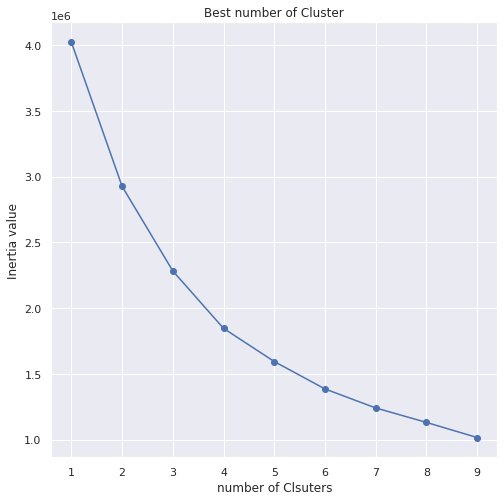

In [139]:
plt.plot(ks,inertias,'-o')
plt.xlabel('number of Clsuters')
plt.ylabel('Inertia value')
plt.xticks(ks)
plt.title('Best number of Cluster')

#### 2160차원 -->(PCA)-->50차원-->(T-SNE) -->3차원 -->(K-means) --> 5-Clustering

In [140]:
full_data_3d

x_3d       y_3d      z_3d
0   11.982762  23.575155  6.599976
1   12.061995  23.530338  6.588207
2   12.178492  23.492624  6.569942
3   12.314672  23.496248  6.538774
4   12.491506  23.525299  6.509665
..        ...        ...       ...
10 -16.966217 -18.763710  0.540063
11 -16.756977 -18.625620  1.175787
12 -16.988192 -18.346315  0.438602
13 -16.678753 -18.893511  1.152005
14 -16.948658 -18.124926  0.553511

[9190 rows x 3 columns]

In [141]:
model_3d=KMeans(n_clusters=5, algorithm='auto')
model_3d.fit(full_data_3d)
predict_3d=pd.DataFrame(model_3d.predict(full_data_3d))
predict_3d.columns=['predict_3d']

KMeans(n_clusters=5)

In [185]:

pd.set_option('display.max_rows', 500)

In [193]:
data_train32.iloc[:,-4:][265:280]

x_3d       y_3d       z_3d  K_Means_3d_5cluster
50   4.208522  -2.982414  19.581553                    3
51   4.492457  -3.173435  19.638924                    3
52   4.152783  -3.100580  19.855511                    3
53   4.497084  -3.048234  19.598194                    3
54   4.339095  -3.126740  19.890202                    3
0   13.068452  12.533747   9.748915                    3
1   13.048501  12.622078   9.655738                    3
2   13.015159  12.738780   9.516710                    3
3   12.967184  12.899315   9.320369                    3
4   12.900416  13.095744   9.057330                    3
5   12.839581  13.261187   8.808485                    0
6   12.778019  13.412553   8.554416                    0
7   12.715396  13.552788   8.283227                    0
8   12.652485  13.698001   7.976607                    0
9   12.599971  13.828048   7.689787                    0

In [180]:
predict_3d

predict_3d
0              0
1              0
2              0
3              0
4              0
...          ...
9185           1
9186           1
9187           1
9188           1
9189           1

[9190 rows x 1 columns]

In [145]:
predict_3d.value_counts()

predict_3d
3             2085
0             2029
2             1936
1             1835
4             1305
dtype: int64

In [ ]:
data_train32['x_3d'

In [146]:
data_train32['K_Means_3d_5cluster']=predict_3d.values

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [159]:
data_train32

channel          genre    sign_in duration video_n_view n_comment n_like  \
0   2B Gamer  Entertainment  2019-9-27   207.62         9676         2      0   
1   2B Gamer  Entertainment  2019-9-27  165.435      10753.5       0.5      0   
2   2B Gamer  Entertainment  2019-9-27   197.78      17747.5       3.5      0   
3   2B Gamer  Entertainment  2019-9-27   204.54        25302   3.66667      0   
4   2B Gamer  Entertainment  2019-9-27  179.715      20621.5         3      0   
..       ...            ...        ...      ...          ...       ...    ...   
10    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
11    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
12    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
13    캣치유캣치미            NaN   2019-7-8        0            0         0      0   
14    캣치유캣치미            NaN   2019-7-8        0            0         0      0   

   n_dislike daily_n_view  cumul_view  ... video_num sub_diff  \
0          0        10500      679200  ...         2     3000   
1          0        25500      741100  ...         3     6000   
2          0        91300      857900  ...         2     3000   
3          0        91100   1.011e+06  ...         3     5000   
4          0        58099  1.1556e+06  ...         2     5000   
..       ...          ...         ...  ...       ...      ...   
10         0         1424      186615  ...         0        0   
11         0         1395      189434  ...         0        0   
12         0         1395      192224  ...         0        0   
13         0         1395      195014  ...         0        0   
14         0         1396      197805  ...         0        0   

   no_upload_interval          x          y K_Means_4       x_3d       y_3d  \
0                   0   4.280610  97.529305         0  11.982762  23.575155   
1                   0   4.283713  97.480560         0  12.061995  23.530338   
2                   0   4.292496  97.392624         0  12.178492  23.492624   
3                   0   4.225615  97.337051         0  12.314672  23.496248   
4                   0   4.100070  97.276268         0  12.491506  23.525299   
..                ...        ...        ...       ...        ...        ...   
10                  5  70.665749  36.545052         0 -16.966217 -18.763710   
11                  7  70.328369  36.229195         0 -16.756977 -18.625620   
12                  1  70.729065  36.892143         0 -16.988192 -18.346315   
13                  3  70.280434  36.052860         0 -16.678753 -18.893511   
14                  5  70.664726  36.990849         0 -16.948658 -18.124926   

        z_3d K_Means_3d_5cluster  
0   6.599976                   0  
1   6.588207                   0  
2   6.569942                   0  
3   6.538774                   0  
4   6.509665                   0  
..       ...                 ...  
10  0.540063                   1  
11  1.175787                   1  
12  0.438602                   1  
13  1.152005                   1  
14  0.553511                   1  

[9190 rows x 3247 columns]

In [161]:
data_train32.to_csv('K_Means_Clustering_full.csv')

In [173]:
data_train32.iloc[:,-4:]

x_3d       y_3d      z_3d  K_Means_3d_5cluster
0   11.982762  23.575155  6.599976                    0
1   12.061995  23.530338  6.588207                    0
2   12.178492  23.492624  6.569942                    0
3   12.314672  23.496248  6.538774                    0
4   12.491506  23.525299  6.509665                    0
..        ...        ...       ...                  ...
10 -16.966217 -18.763710  0.540063                    1
11 -16.756977 -18.625620  1.175787                    1
12 -16.988192 -18.346315  0.438602                    1
13 -16.678753 -18.893511  1.152005                    1
14 -16.948658 -18.124926  0.553511                    1

[9190 rows x 4 columns]

In [175]:
data_train32.iloc[:,-4:].to_csv('K_Means_Clustering_lite.csv')

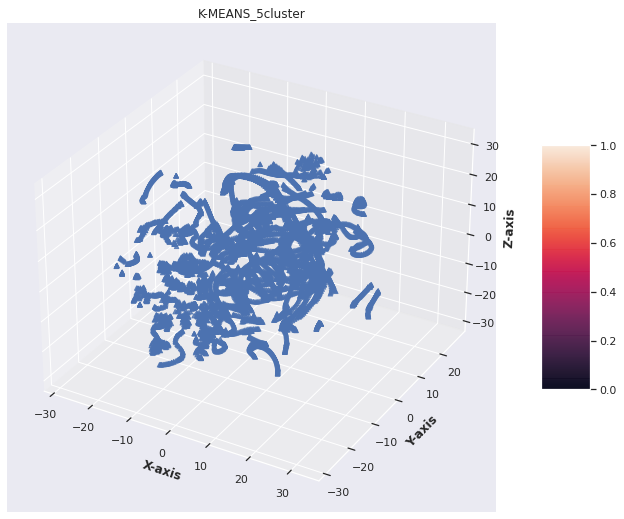

In [157]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 

sctt = ax.scatter3D(data_train32['x_3d'], data_train32['y_3d'], 
                    data_train32['z_3d'],
                    alpha = 0.8, 
                    marker ='^')
 
plt.title("K-MEANS_5cluster")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

<AxesSubplot:xlabel='x_3d', ylabel='z_3d'>

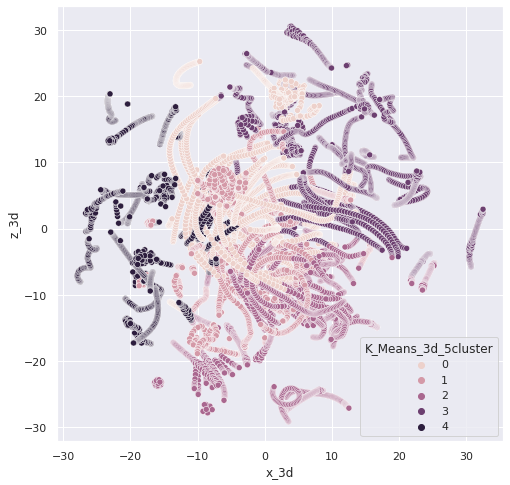

In [154]:
sns.scatterplot(data=data_train32,x='x_3d',y='z_3d', hue='K_Means_3d_5cluster')

### 시계열 말고 raw data로 진행

In [129]:
raw_data=loader2._raw
#왜 loader의 raw가 변해있지.

In [131]:
drop_features = ['date','genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
raw_drop=raw_data[drop_features]

In [132]:
raw_data=raw_data.drop(drop_features, axis=1)

In [135]:
# plotting용
raw_drop

date           genre  \
0      2019-12-03             NaN   
1      2019-12-04             NaN   
2      2019-12-05  People & Blogs   
3      2019-12-06             NaN   
4      2019-12-07             NaN   
...           ...             ...   
12440  2020-11-23             NaN   
12441  2020-11-24             NaN   
12442  2020-11-25             NaN   
12443  2020-11-26             NaN   
12444  2020-11-27             NaN   

                                                   title        channel  \
0                                                    NaN  Tatiana DeVoe   
1                                                    NaN  Tatiana DeVoe   
2      Q&A: Je suis espagnole ? J’ai gagné 20k abonné...  Tatiana DeVoe   
3                                                    NaN  Tatiana DeVoe   
4                                                    NaN  Tatiana DeVoe   
...                                                  ...            ...   
12440                                                NaN        NeoxiTV   
12441                                                NaN        NeoxiTV   
12442                                                NaN        NeoxiTV   
12443                                                NaN        NeoxiTV   
12444                                                NaN        NeoxiTV   

                                             description    sign_in  \
0                                                    NaN  2019-9-18   
1                                                    NaN  2019-9-18   
2      Salut tout le monde ! \n\nDans cette video je ...  2019-9-18   
3                                                    NaN  2019-9-18   
4                                                    NaN  2019-9-18   
...                                                  ...        ...   
12440                                                NaN  2019-9-12   
12441                                                NaN  2019-9-12   
12442                                                NaN  2019-9-12   
12443                                                NaN  2019-9-12   
12444                                                NaN  2019-9-12   

       current_cumul_view  current_n_video  current_cumul_subs  
0                 1621877               19               54800  
1                 1621877               19               54800  
2                 1621877               19               54800  
3                 1621877               19               54800  
4                 1621877               19               54800  
...                   ...              ...                 ...  
12440             2025975               16              146000  
12441             2025975               16              146000  
12442             2025975               16              146000  
12443             2025975               16              146000  
12444             2025975               16              146000  

[12445 rows x 9 columns]

In [136]:
raw_data

duration  video_n_view n_comment  n_like  n_dislike  daily_n_view  \
0           NaN           NaN       NaN     NaN        NaN          7659   
1           NaN           NaN       NaN     NaN        NaN          7659   
2         23.27       41808.0     446.0  4112.0       21.0          9609   
3           NaN           NaN       NaN     NaN        NaN         14500   
4           NaN           NaN       NaN     NaN        NaN         11200   
...         ...           ...       ...     ...        ...           ...   
12440       NaN           NaN       NaN     NaN        NaN          5959   
12441       NaN           NaN       NaN     NaN        NaN          2021   
12442       NaN           NaN       NaN     NaN        NaN          6120   
12443       NaN           NaN       NaN     NaN        NaN          1907   
12444       NaN           NaN       NaN     NaN        NaN          1907   

       cumul_view  cumul_subs  
0          254659       21900  
1          262318       22200  
2          271927       22599  
3          286427       23200  
4          297627       23900  
...           ...         ...  
12440     2005171      145000  
12441     2007192      145000  
12442     2013312      145000  
12443     2015219      145500  
12444     2017126      146000  

[12445 rows x 8 columns]

In [187]:
raw_data=raw_data.drop(['n_comment'],axis=1)

> scale 후의 data를 이용

In [188]:
scaler2=MinMaxScaler()
scaled_raw_data=scaler.fit_transform(raw_data)

> (12445개의 channel, 7개의 feature)

In [189]:
scaled_raw_data.shape

(12445, 7)

In [195]:
pd.DataFrame(scaled_raw_data).fillna(0)

0         1         2        3         4         5         6
0      0.00000  0.000000  0.000000  0.00000  0.450203  0.002454  0.019381
1      0.00000  0.000000  0.000000  0.00000  0.450203  0.002528  0.019646
2      0.03218  0.007892  0.023418  0.00324  0.450331  0.002621  0.019999
3      0.00000  0.000000  0.000000  0.00000  0.450651  0.002761  0.020531
4      0.00000  0.000000  0.000000  0.00000  0.450435  0.002869  0.021150
...        ...       ...       ...      ...       ...       ...       ...
12440  0.00000  0.000000  0.000000  0.00000  0.450091  0.019328  0.128319
12441  0.00000  0.000000  0.000000  0.00000  0.449833  0.019348  0.128319
12442  0.00000  0.000000  0.000000  0.00000  0.450102  0.019407  0.128319
12443  0.00000  0.000000  0.000000  0.00000  0.449826  0.019425  0.128761
12444  0.00000  0.000000  0.000000  0.00000  0.449826  0.019443  0.129204

[12445 rows x 7 columns]

In [190]:
pca2=PCA(n_components=50) # 50d까지.
reducted_50d2=pca2.fit_transform(scaled_train_data)

In [196]:
reducted_2d2=TSNE(n_components=2).fit_transform(pd.DataFrame(scaled_raw_data).fillna(0))

In [197]:
x2,y2=reducted_2d2[:,0], reducted_2d2[:,1]

In [198]:
raw_drop['x']=x2
raw_drop['y']=y2

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12431 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12304 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mskang/wh

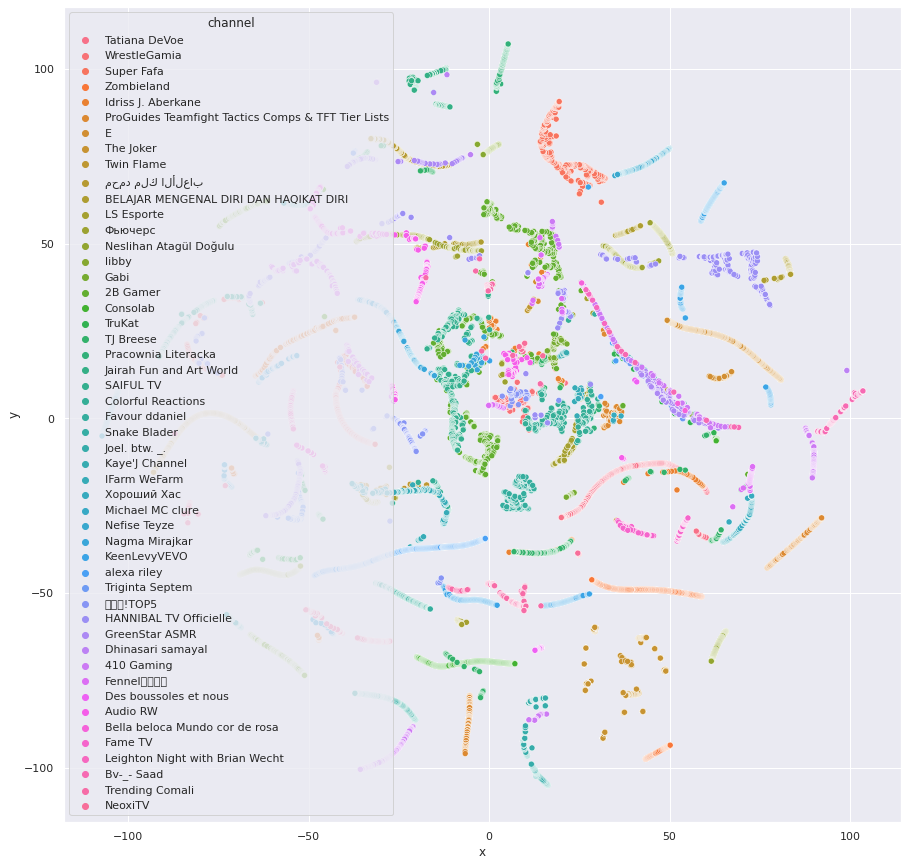

In [202]:
sns.scatterplot(data=raw_drop, x='x',y='y', hue='channel')
sns.set(rc={'figure.figsize':(12,12)})

<AxesSubplot:xlabel='x', ylabel='y'>

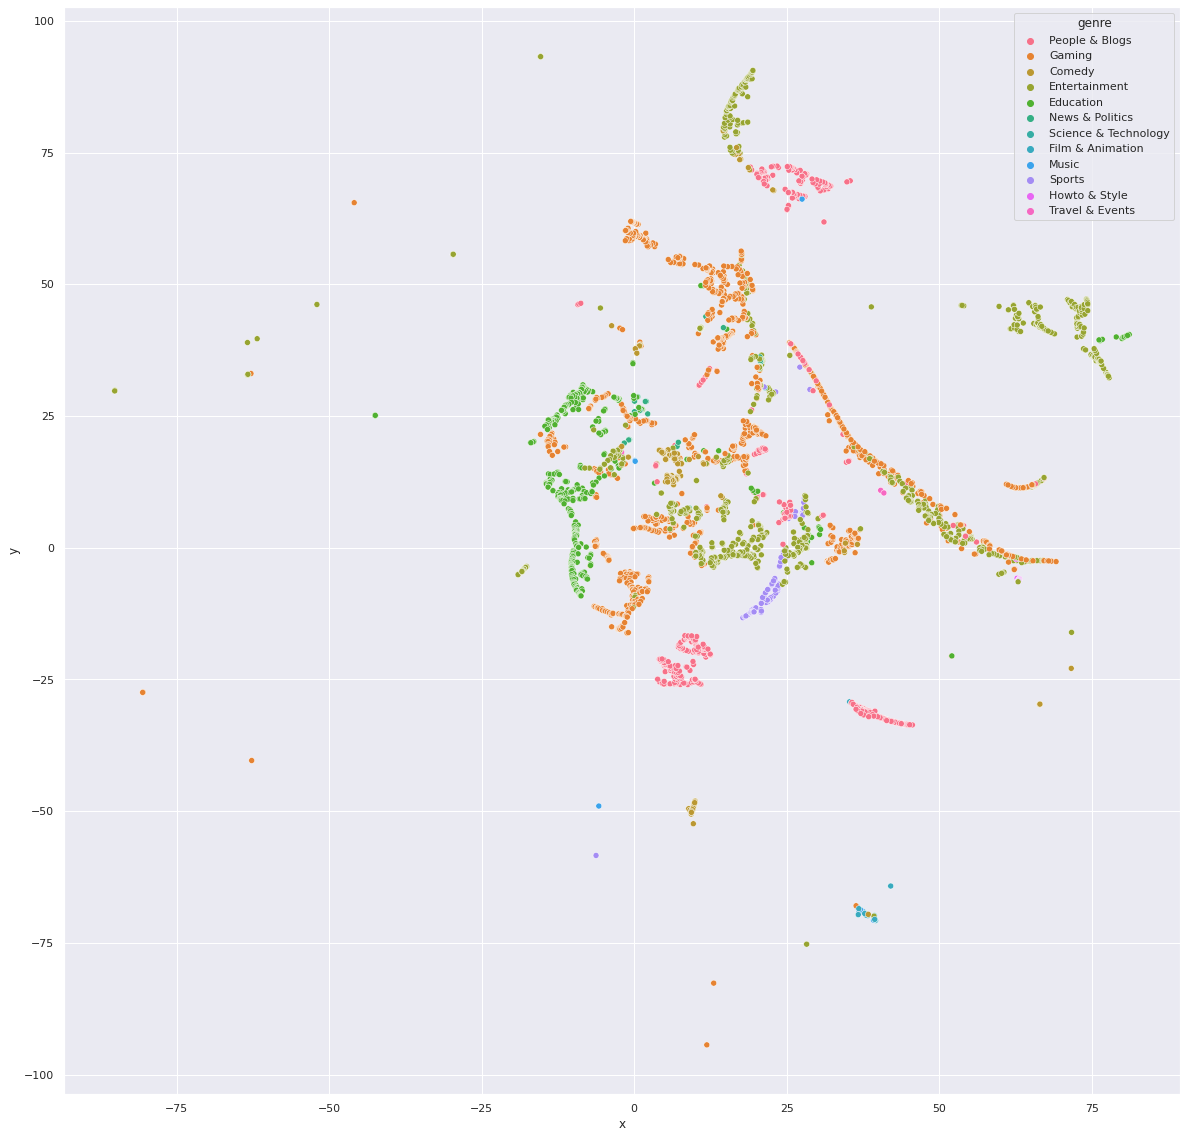

In [207]:
sns.set(rc={'figure.figsize':(20,20)})
sns.scatterplot(data=raw_drop, x='x',y='y', hue='genre')


> 산점도

## Change data's dimension from 2d to 3d

In [31]:
scaler=sklearn.preprocessing.MinMaxScaler()

NameError: name 'sklearn' is not defined

In [4]:
def stack_to_multi(df):
    feature_num=len(set(df.columns))
    window_num=int(df.shape[1]/feature_num)
    sample_num=int(df.shape[0])
    temp=np.empty([sample_num,window_num,feature_num])
    for i in range(feature_num):
        temp[:,:,i]=df.iloc[:,window_num*i:window_num*i+window_num]
    
    return temp
    

In [5]:
data_train=stack_to_multi(data_train)

NameError: name 'data_train' is not defined

In [12]:
print(data_train.shape)
print(data_label.shape)

(3614, 180, 4)
(3614, 7)


In [13]:
# 트레인, 테스트 나누기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_train, data_label, test_size=0.3, random_state=7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=7)

In [34]:
# 트레인, 테스트 나누기
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train2, y_test2 = train_test_split(data_train2, data_label2, test_size=0.3, random_state=7)
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_test2, y_test2, test_size=0.5, random_state=7)

In [14]:
print("x_train's shape: ", x_train.shape) 
print("y_train's shape: ", y_train.shape) 
print("x_val's shape: ", x_val.shape)
print("y_val's shape: ", y_val.shape)
print("x_test's shape: ", x_test.shape)
print("y_test's shape: ", y_test.shape)

x_train's shape:  (2529, 180, 4)
y_train's shape:  (2529, 7)
x_val's shape:  (542, 180, 4)
y_val's shape:  (542, 7)
x_test's shape:  (543, 180, 4)
y_test's shape:  (543, 7)


In [15]:
scaler=preprocessing.MinMaxScaler()
scaler_y=preprocessing.MinMaxScaler()

### 스케일링

In [16]:
from sklearn.preprocessing import MinMaxScaler
def fit_3d(x_train,x_val,x_test):
    x_train_sample = x_train.shape[0] #샘플 개수
    x_val_sample=x_val.shape[0]
    x_test_sample=x_test.shape[0]
    
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1,results2,results3=([],[],[])
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))
        results2.append(scaler.transform(x_val[:,ss,:]).reshape(x_val_sample,1,x_feature))
        results3.append(scaler.transform(x_test[:,ss,:]).reshape(x_test_sample,1,x_feature))
    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    df_val_scaled=np.concatenate(results2,axis=1)
    df_test_scaled=np.concatenate(results3,axis=1)
    
    return df_train_scaled,df_val_scaled,df_test_scaled

In [548]:
x_train_copy

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21118012e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.08074534e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.14285714e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.08074534e-03]],

       [[6.09489550e-02, 2.63724070e-02, 1.12463429e-01, 3.72670807e-02],
        